# <font size = 5> Notes</font>

Part 3 of 5: Understanding Na + K Feshbach resonances and NaK Feshbach molecules

Author: Huan Q. Bui

Affiliation: Fermi1 experiment at Zlabs, MIT
             
PI: Professor Martin Zwierlein

First updated: May 15, 2023

Last updated: August 13, 2023

# <font size = 5>Setting up</font>

In [1]:
# imports
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import patches
import os
import scipy
from scipy.optimize import fsolve
import pandas as pd
from qutip import *
import time
from findiff import FinDiff
from numba import jit
# for diatomic hyperfine + rotational stuff
from sympy.physics.wigner import wigner_3j
from scipy.linalg import block_diag
import scipy.constants
from scipy.special import sph_harm
from matplotlib import pyplot,gridspec,colors,patches,collections
from sympy.physics.wigner import wigner_3j, wigner_6j, clebsch_gordan

In [2]:
# suppress warnings: do at your own risk!
import warnings
warnings.filterwarnings("ignore")

In [3]:
# constants
ABSORPTION_LIMIT = 5.0
SPECIAL_CHARACTERS = "!@#$%^&*()-+?_=,<>/"

# physics constants
hbar = 1.05457182*10**(-34) # Js
c = 299792458 # m/s
h_planck = hbar*2*np.pi  # Js
me = 9.1093837015e-31    # electron mass
mn = 1.67493e-27         # neutron mass
eC = 1.60218e-19         # electric charge
muB = eC*hbar/(2*me)     # Bohr magneton
muB_cm1_G = muB / (100*c*h_planck*1e4) # Bohr magneton in units of cm-1 per Gauss
a0 = 5.2917720859e-11    # Bohr radius
muN = scipy.constants.physical_constants['nuclear magneton'][0]
eps0 = scipy.constants.epsilon_0
gS = 2.0023193043622
kB = 1.380649e-23 
DebyeSI = 3.33564e-30

# Lithium constants
mLi6 = 9.9883414*10**(-27) # kg
Li6D2Gamma = 5.8724e6 # Hz Note that this is NOT angular freq
Li6D2lambda0 = 670.977338*10**(-9) # meters
Li6D2sigma0 = 3*(Li6D2lambda0)**2/(2*np.pi)
Li6Ahf_s12 = 152.1368407e6  # This is NOT angular freq
Li6Bhf_s12 = 0
Li6Ahf_p12 = 17.386e6 # Hz
Li6Bhf_p12 = 0
Li6Ahf_p32 = -1.155e6 # Hz
Li6Bhf_p32 = -0.10e6 # Hz
Li6I = 1
Li6gI = -0.0004476540

# Sodium-23 constants
mNa23 = 0.38175403519e-25 # kg
Na23D2Gamma = 9.794646e6 # Hz
Na23D2lambda0 = 589.158326415e-9 # meters
Na23D2sigma0 = 3*(Na23D2lambda0)**2/(2*np.pi)
Na23Ahf_s12 = 885.8130644050e6 # Hz
Na23Bhf_s12 = 0e6 # Hz
Na23Ahf_p12 = 94.4413e6 # Hz
Na23Bhf_p12 = 0e6 # Hz
Na23Ahf_p32 = 18.53415e6 # Hz
Na23Bhf_p32 = 2.72430e6 # Hz
Na23I = 3/2
Na23gI = -0.0008046108080

# Potassium-40 constants
mK40 = 39.9639984821*1.6605402e-27 # kg 
K40D2Gamma = 6.03511 # MHz
K40D2lambda0 = 766.700674872173e-9 # meters
K40D2sigma0 = 3*(K40D2lambda0)**2/(2*np.pi)
K40Ahf_s12 = -285.730824e6 # Hz
K40Bhf_s12 = 0
K40Ahf_p12 = -34.52325e6 # Hz
K40Bhf_p12 = 0
K40Ahf_p32 = -7.58510e6 # Hz
K40Bhf_p32 = -3.44590e6 # Hz
K40I = 4
K40gI = 0.00017649034

# NaK constants:
mK41 = 6.80187059497004e-26 # kg
mK40 = 6.63617749148248e-26 # kg
mK39 = 6.47007514485677e-26 # kg
u = 1.660538782e-27  # kg
Eh = 4.35974394e-18 
RKRcst = hbar/np.sqrt(2*u) * (10**10) * np.sqrt(1/(100 * c * hbar * 2*np.pi)) 
muNa39K = (mNa23 * mK39)/(mNa23 + mK39) * 1/u # atomic units
muNa40K = (mNa23 * mK40)/(mNa23 + mK40) * 1/u # atomic units 
muNa41K = (mNa23 * mK41)/(mNa23 + mK41) * 1/u # atomic units

In [4]:
# NaK39 molecular constants, to be rescaled to NaK40 via RKR
DeX = 5273.6205    # minimum of the X1S+ GS, according to Tiemann

# B1Pi potential
# data source: http://dx.doi.org/10.1063/1.460157
TeB1Pi = 16992.7446
v_max_B1Pi = 43
# 23Na39K Dunham coefficients:
Y_Na39K_B1Pi = np.zeros((10,3))
Y_Na39K_B1Pi[0][0] = -0.0430
Y_Na39K_B1Pi[1][0] = 71.4630
Y_Na39K_B1Pi[2][0] = -1.15092
Y_Na39K_B1Pi[3][0] = -1.0613e-2
Y_Na39K_B1Pi[4][0] = 9.9950e-4
Y_Na39K_B1Pi[5][0] = -1.42656e-5
Y_Na39K_B1Pi[6][0] = -8.67783e-7
Y_Na39K_B1Pi[7][0] = 4.74996e-8
Y_Na39K_B1Pi[8][0] = -9.30786e-10
Y_Na39K_B1Pi[9][0] = 6.67343e-12
Y_Na39K_B1Pi[0][1] = 7.23853e-2
Y_Na39K_B1Pi[1][1] = -1.17799e-3
Y_Na39K_B1Pi[2][1] = -1.3502e-5
Y_Na39K_B1Pi[3][1] = -4.7933e-7
Y_Na39K_B1Pi[4][1] = 4.82977e-8
Y_Na39K_B1Pi[5][1] = -6.88606e-10
Y_Na39K_B1Pi[6][1] = -1.13984e-11
Y_Na39K_B1Pi[7][1] = 2.09534e-13
Y_Na39K_B1Pi[0][2] = -2.89859e-7
Y_Na39K_B1Pi[1][2] = -1.93901e-8
Y_Na39K_B1Pi[2][2] = 6.45399e-10
Y_Na39K_B1Pi[3][2] = -7.75355e-12
Y_Na39K_B1Pi[4][2] = 9.91847e-13
Y_Na39K_B1Pi[5][2] = -3.46351e-14

# c3SigmaPlus potential
# data source: http://dx.doi.org/10.1063/1.460157 Table IV.
Te_c3SigmaPlus = 15750.64
v_max_c3SigmaPlus = 36 # see paper 
Y_Na39K_c3SigmaPlus = np.zeros((4,4))
Y_Na39K_c3SigmaPlus[1][0] = 73.4
Y_Na39K_c3SigmaPlus[2][0] = -0.480173
Y_Na39K_c3SigmaPlus[3][0] = -9.82485e-4
Y_Na39K_c3SigmaPlus[0][1] = 0.06275
Y_Na39K_c3SigmaPlus[1][1] = -5.91425e-4
Y_Na39K_c3SigmaPlus[2][1] = -1.81058e-6
Y_Na39K_c3SigmaPlus[0][2] = 1.83e-7
Y_Na39K_c3SigmaPlus[1][2] = 3.45e-9
Y_Na39K_c3SigmaPlus[2][2] = -2.17e-11
r_Ferber = np.array([3.3602, 3.3683, 3.3763, 3.3845, 3.3928, 3.4013, 3.4100, 3.4188, 3.4280, 3.4374, 3.4471, 3.4571, 3.4675, 3.4783, 3.4895, 3.5012, 3.5135, 3.5263, 3.5397, 
                  3.5538, 3.5687, 3.5844, 3.6011, 3.6187, 3.6375, 3.6576, 3.6792, 3.7025, 3.7279, 3.7556, 3.7862, 3.8204, 3.8593, 3.9047, 3.9596, 4.0309, 4.1422, 
                  4.4997, 4.6535, 4.7679, 4.8666, 4.9564, 5.0405, 5.1206, 5.1978, 5.2729, 5.3464, 5.4188, 5.4903, 5.5611, 5.6317, 5.7020, 5.7723, 5.8427, 5.9133, 5.9843,
                  6.0558, 6.1278, 6.2006, 6.2741, 6.3485, 6.4240, 6.5006, 6.5783, 6.6574, 6.7380, 6.8201, 6.9040, 6.9897, 7.0773, 7.1672, 7.2593, 7.3540, 7.4514])
U_Ferber = np.array([1991.62, 1956.61, 1920.44, 1883.09, 1844.60, 1804.95, 1764.15, 1722.21, 1679.14, 1634.94, 1589.62, 1543.18, 1495.63, 1446.98, 1397.23, 1346.38, 
                        1294.45, 1241.44, 1187.35, 1132.19, 1075.97, 1018.69, 960.35, 900.98, 840.56, 779.11, 716.63, 653.13, 588.61, 523.08, 456.55, 389.02, 320.49, 250.98, 
                        180.49, 109.02, 36.59, 36.59,  109.02,  180.49,  250.98,  320.49,  389.02,  456.55, 523.08,  588.61,  653.13,  716.63,  779.11,  840.56,  900.98,
                        960.35, 1018.69, 1075.97, 1132.19, 1187.35, 1241.44, 1294.45, 1346.38, 1397.23, 1446.98, 1495.63, 1543.18, 1589.62, 1634.94, 1679.14, 1722.21, 
                        1764.15, 1804.95, 1844.6 , 1883.09, 1920.44, 1956.61, 1991.62])

# b3Pi potential
# data source: https://doi.org/10.1063/1.481149
Te_b3Pi = 11562.18
v_max_b3Pi = 63
Y_Na39K_b3Pi = np.zeros((8,3))
Y_Na39K_b3Pi[1][0] = 120.371380
Y_Na39K_b3Pi[2][0] = -0.332024
Y_Na39K_b3Pi[3][0] = -0.104098e-2
Y_Na39K_b3Pi[4][0] = 0.386127e-4
Y_Na39K_b3Pi[5][0] = -0.123100e-5
Y_Na39K_b3Pi[6][0] = 0.143700e-7
Y_Na39K_b3Pi[7][0] = 0-0.805024e-10
Y_Na39K_b3Pi[0][1] = 0.950673e-1
Y_Na39K_b3Pi[1][1] = -0.328708e-3
Y_Na39K_b3Pi[2][1] = -0.205156e-5
Y_Na39K_b3Pi[3][1] = 0.361430e-7
Y_Na39K_b3Pi[4][1] = -0.186723e-8
Y_Na39K_b3Pi[5][1] = 0.278352e-10
Y_Na39K_b3Pi[6][1] = -0.235550e-12
Y_Na39K_b3Pi[0][2] = -0.230157e-6
Y_Na39K_b3Pi[1][2] = -0.178322e-8
Y_Na39K_b3Pi[2][2] = 0.802326e-10
Y_Na39K_b3Pi[3][2] = -0.159840e-11

# A1SigmaPlus potential
# data source: Ross, Clements, Barrow, J. Mol. Spec. 127, 546-548 (1988) 
# this source is not increadibly easy to find, but I have pdf
Te_A1SigmaPlus = 12137.272
v_max_A1SigmaPlus = 75 # see paper as well
Y_Na39K_A1SigmaPlus = np.zeros((7,3))
Y_Na39K_A1SigmaPlus[1][0] = 81.250506
Y_Na39K_A1SigmaPlus[2][0] = - 0.27470815    # see Dunham-molecular constant table
Y_Na39K_A1SigmaPlus[3][0] = 0.41931994e-2
Y_Na39K_A1SigmaPlus[4][0] = -0.7720508e-4
Y_Na39K_A1SigmaPlus[5][0] = 0.6932446e-6
Y_Na39K_A1SigmaPlus[6][0] = -0.282698e-8
Y_Na39K_A1SigmaPlus[0][1] = 0.0661371
Y_Na39K_A1SigmaPlus[1][1] = - 0.360162e-3  # see Dunham-molecular constant table
Y_Na39K_A1SigmaPlus[2][1] = 0.3300504e-5
Y_Na39K_A1SigmaPlus[3][1] = -0.3409183e-7
Y_Na39K_A1SigmaPlus[0][2] = 0.16600e-6
Y_Na39K_A1SigmaPlus[1][2] = -0.6343e-9

# X1SP potential:
v_max_X1SigmaPlus = 62 # see Tiemann (2008) paper
Y_Na39K_X1SigmaPlus = np.zeros((17,5))
Y_Na39K_X1SigmaPlus[0][0]  = -0.0242
Y_Na39K_X1SigmaPlus[1][0]  = 124.00869
Y_Na39K_X1SigmaPlus[2][0]  = -0.48518740
Y_Na39K_X1SigmaPlus[3][0]  = -0.32143996e-2
Y_Na39K_X1SigmaPlus[4][0]  = 0.31299010e-3
Y_Na39K_X1SigmaPlus[5][0]  = -0.28723065e-4
Y_Na39K_X1SigmaPlus[6][0]  = 0.16126212e-5
Y_Na39K_X1SigmaPlus[7][0]  = -0.60792476e-7
Y_Na39K_X1SigmaPlus[8][0]  = 0.15455135e-8
Y_Na39K_X1SigmaPlus[9][0]  = -0.26202271e-10
Y_Na39K_X1SigmaPlus[10][0] = 0.28401146e-12
Y_Na39K_X1SigmaPlus[11][0] = -0.17819948e-14
Y_Na39K_X1SigmaPlus[12][0] = 0.49310577e-17
Y_Na39K_X1SigmaPlus[0][1]  = 0.95229083e-1
Y_Na39K_X1SigmaPlus[1][1]  = -0.44671511e-3
Y_Na39K_X1SigmaPlus[2][1]  = -0.40119066e-5
Y_Na39K_X1SigmaPlus[3][1]  = 0.36729987e-6
Y_Na39K_X1SigmaPlus[4][1]  = -0.54647786e-7
Y_Na39K_X1SigmaPlus[5][1]  = 0.42699577e-8
Y_Na39K_X1SigmaPlus[6][1]  = -0.21018754e-9
Y_Na39K_X1SigmaPlus[7][1]  = 0.66546163e-11
Y_Na39K_X1SigmaPlus[8][1]  = -0.13577705e-12
Y_Na39K_X1SigmaPlus[9][1]  = 0.17245153e-14
Y_Na39K_X1SigmaPlus[10][1] = -0.12404785e-16
Y_Na39K_X1SigmaPlus[11][1] = 0.38567732e-19
Y_Na39K_X1SigmaPlus[0][2]  = -0.22514747e-6
Y_Na39K_X1SigmaPlus[1][2]  = -0.69379810e-9
Y_Na39K_X1SigmaPlus[2][2]  = -0.38450884e-9
Y_Na39K_X1SigmaPlus[3][2]  = 0.67000514e-10
Y_Na39K_X1SigmaPlus[4][2]  = -0.64846359e-11
Y_Na39K_X1SigmaPlus[5][2]  = 0.36911427e-12
Y_Na39K_X1SigmaPlus[6][2]  = -0.13087875e-13
Y_Na39K_X1SigmaPlus[7][2]  = 0.29228842e-15
Y_Na39K_X1SigmaPlus[8][2]  = -0.40139465e-17
Y_Na39K_X1SigmaPlus[9][2]  = 0.33230366e-19
Y_Na39K_X1SigmaPlus[10][2] = -0.21707093e-21
Y_Na39K_X1SigmaPlus[11][2] = 0.19607647e-23
Y_Na39K_X1SigmaPlus[12][2] = -0.11413562e-25
Y_Na39K_X1SigmaPlus[0][3]  = 0.52399300e-12
Y_Na39K_X1SigmaPlus[1][3]  = 0.46401290e-15
Y_Na39K_X1SigmaPlus[2][3]  = 0.89297698e-15
Y_Na39K_X1SigmaPlus[3][3]  = -0.93109347e-16
Y_Na39K_X1SigmaPlus[4][3]  = 0.28480050e-17
Y_Na39K_X1SigmaPlus[5][3]  = -0.26731300e-17
Y_Na39K_X1SigmaPlus[6][3]  = 0.62287532e-18
Y_Na39K_X1SigmaPlus[7][3]  = -0.62087407e-19
Y_Na39K_X1SigmaPlus[8][3]  = 0.34243139e-20
Y_Na39K_X1SigmaPlus[9][3]  = -0.11566210e-21
Y_Na39K_X1SigmaPlus[10][3] = 0.24468622e-23
Y_Na39K_X1SigmaPlus[11][3] = -0.31442801e-25
Y_Na39K_X1SigmaPlus[12][3] = 0.22286972e-27
Y_Na39K_X1SigmaPlus[13][3] = -0.66367690e-30
Y_Na39K_X1SigmaPlus[0][4]  = -0.28530786e-17
Y_Na39K_X1SigmaPlus[1][4]  = -0.23417169e-18
Y_Na39K_X1SigmaPlus[2][4]  = 0.37965748e-19
Y_Na39K_X1SigmaPlus[3][4]  = -0.39626221e-20
Y_Na39K_X1SigmaPlus[4][4]  = 0.16621617e-21
Y_Na39K_X1SigmaPlus[5][4]  = -0.20577878e-23
Y_Na39K_X1SigmaPlus[6][4]  = -0.92961944e-25
Y_Na39K_X1SigmaPlus[7][4]  = 0.36175686e-26
Y_Na39K_X1SigmaPlus[8][4]  = 0.20473210e-26
Y_Na39K_X1SigmaPlus[9][4]  = -0.33208635e-27
Y_Na39K_X1SigmaPlus[10][4] = 0.23016573e-28
Y_Na39K_X1SigmaPlus[11][4] = -0.46234771e-30
Y_Na39K_X1SigmaPlus[12][4] = -0.16267367e-31
Y_Na39K_X1SigmaPlus[13][4] = 0.10022499e-32
Y_Na39K_X1SigmaPlus[14][4] = -0.20583609e-34
Y_Na39K_X1SigmaPlus[15][4] = 0.19693909e-36
Y_Na39K_X1SigmaPlus[16][4] = -0.74212648e-39

# X1SigmaPlus, analytic potential for Na39K, from https://arxiv.org/pdf/1810.00608.pdf (Hanover, PRA 032711, 2019)
Ri_X1SigmaPlus = 2.617
Ro_X1SigmaPlus = 11.30
A_X1SigmaPlus = -0.7205185e4
B_X1SigmaPlus = 0.696124608e6
q_X1SigmaPlus = 4.92948
b_X1SigmaPlus   = -0.4
Rm_X1SigmaPlus = 3.49901422
a_X1SigmaPlus = np.zeros(31)
a_X1SigmaPlus[0] = -5273.62315
a_X1SigmaPlus[1] = -0.239542348630413837e1
a_X1SigmaPlus[2] = 0.145382657416013644e5
a_X1SigmaPlus[3] = 0.114848641509625941e5
a_X1SigmaPlus[4] = -0.393070200439200050e3
a_X1SigmaPlus[5] = -0.169145814548076414e5
a_X1SigmaPlus[6] = -0.374171063602873910e5
a_X1SigmaPlus[7] = 0.106844724280541472e6
a_X1SigmaPlus[8] = 0.549571543607791886e6
a_X1SigmaPlus[9] = -0.216398544375193026e7
a_X1SigmaPlus[10] = -0.101610099703415297e8
a_X1SigmaPlus[11] = 0.221444819359695017e8
a_X1SigmaPlus[12] = 0.109959157819038272e9
a_X1SigmaPlus[13] = -0.154974082312119037e9
a_X1SigmaPlus[14] = -0.782460601529465795e9
a_X1SigmaPlus[15] = 0.764737042077244759e9
a_X1SigmaPlus[16] = 0.381868029858328533e10
a_X1SigmaPlus[17] = -0.270560975156805658e10
a_X1SigmaPlus[18] = -0.130777134652790947e11
a_X1SigmaPlus[19] = 0.693123967590401554e10
a_X1SigmaPlus[20] = 0.317969910129808044e11
a_X1SigmaPlus[21] = -0.127583274381506557e11
a_X1SigmaPlus[22] = -0.547443981078124619e11
a_X1SigmaPlus[23] = 0.164038438389521656e11
a_X1SigmaPlus[24] = 0.653485806778233261e11
a_X1SigmaPlus[25] = -0.139350456346844196e11
a_X1SigmaPlus[26] = -0.514892853898448334e11
a_X1SigmaPlus[27] = 0.700668473929830647e10
a_X1SigmaPlus[28] = 0.240948997045685349e11
a_X1SigmaPlus[29] = -0.157575108054349303e10
a_X1SigmaPlus[30] = -0.507254397888037300e10
C6_X1SigmaPlus = 0.1184012e8
C8_X1SigmaPlus = 0.3261886e9
C10_X1SigmaPlus = 0.6317249e10
Aex_X1SigmaPlus = 0.41447134e4
gamma_X1SigmaPlus = 5.25669
beta_X1SigmaPlus = 2.11445

# X1SigmaPlus, analytic potential for Na39K, Tiemann 2008 version:
Ri_X1SigmaPlus_2008 = 2.553 # typo fixed, used to be Ri = 2.53 A
Ro_X1SigmaPlus_2008 = 11.30
A_X1SigmaPlus_2008 = -0.44525554e4
B_X1SigmaPlus_2008 = 10711284.0  # another typo here, corrected
q_X1SigmaPlus_2008 = 8.3980
b_X1SigmaPlus_2008   = -0.4
Rm_X1SigmaPlus_2008 = 3.49901422
a_X1SigmaPlus_2008 = np.zeros(31)
a_X1SigmaPlus_2008[0] = -5273.6205
a_X1SigmaPlus_2008[1] = -0.1254
a_X1SigmaPlus_2008[2] = 0.14536158e5
a_X1SigmaPlus_2008[3] = 0.11484948e5
a_X1SigmaPlus_2008[4] = -0.3902171e3
a_X1SigmaPlus_2008[5] = -0.16931635e5
a_X1SigmaPlus_2008[6] = -0.374520762e5
a_X1SigmaPlus_2008[7] = 0.106906160e6
a_X1SigmaPlus_2008[8] = 0.5495867136e6
a_X1SigmaPlus_2008[9] = -0.2164021160e7
a_X1SigmaPlus_2008[10] = -0.10160808788e8
a_X1SigmaPlus_2008[11] = 0.22144308806e8
a_X1SigmaPlus_2008[12] = 0.10995928468e9
a_X1SigmaPlus_2008[13] = -0.15497420539e9
a_X1SigmaPlus_2008[14] = -0.782460886034e9
a_X1SigmaPlus_2008[15] = 0.764737283856e9
a_X1SigmaPlus_2008[16] = 0.3818679376129e10
a_X1SigmaPlus_2008[17] = -0.270560881733e10
a_X1SigmaPlus_2008[18] = -0.1307771478369e11
a_X1SigmaPlus_2008[19] = 0.6931241396136e10
a_X1SigmaPlus_2008[20] = 0.3179698977691e11
a_X1SigmaPlus_2008[21] = -0.1275832531699e11
a_X1SigmaPlus_2008[22] = -0.5474439830834e11
a_X1SigmaPlus_2008[23] = 0.1640384471424e11
a_X1SigmaPlus_2008[24] = 0.6534858404306e11
a_X1SigmaPlus_2008[25] = -0.139350481085e11
a_X1SigmaPlus_2008[26] = -0.5148927815627e11
a_X1SigmaPlus_2008[27] = 0.700666554236e10
a_X1SigmaPlus_2008[28] = 0.240949154116e11
a_X1SigmaPlus_2008[29] = -0.15757958492e10
a_X1SigmaPlus_2008[30] = -0.50725039078e10
C6_X1SigmaPlus_2008 = 0.1179302e8
C8_X1SigmaPlus_2008 = 0.3023023e9
C10_X1SigmaPlus_2008 = 0.9843378e10
Aex_X1SigmaPlus_2008 = 0.1627150e4
gamma_X1SigmaPlus_2008 = 5.25669
beta_X1SigmaPlus_2008 = 2.11445


# a3SigmaPlus potential, Dunham coefs from Tiemann's 2008 paper
v_max_a3SigmaPlus = 18
Te_a3SigmaPlus = 207.8210     # from Table 3 of Tiemann's 2008 paper
Y_Na39K_a3SigmaPlus = np.zeros((8, 5))
Y_Na39K_a3SigmaPlus[1][0] = 23.009914
Y_Na39K_a3SigmaPlus[2][0] = -0.6216925
Y_Na39K_a3SigmaPlus[4][0] = -0.262754e-3
Y_Na39K_a3SigmaPlus[5][0] = 0.252866e-4
Y_Na39K_a3SigmaPlus[6][0] = -0.162332e-5
Y_Na39K_a3SigmaPlus[7][0] = 0.481156e-7
Y_Na39K_a3SigmaPlus[0][1] = 0.039398428 
Y_Na39K_a3SigmaPlus[1][1] = -0.12512381e-2
Y_Na39K_a3SigmaPlus[2][1] = 0.19715e-5
Y_Na39K_a3SigmaPlus[3][1] = -0.1808271e-5
Y_Na39K_a3SigmaPlus[0][2] = -0.5147070e-6
Y_Na39K_a3SigmaPlus[3][2] = -0.183519e-08
Y_Na39K_a3SigmaPlus[4][2] = 0.168217e-09
Y_Na39K_a3SigmaPlus[6][2] = -0.350225e-12
Y_Na39K_a3SigmaPlus[2][3] = -0.258817e-11
Y_Na39K_a3SigmaPlus[3][3] = 0.859381e-12
Y_Na39K_a3SigmaPlus[4][3] = -0.604052e-13
Y_Na39K_a3SigmaPlus[3][4] = -0.396259e-16

# a3SigmaPlus potential, analytic expression from Hanover, https://arxiv.org/pdf/1810.00608.pdf
Ri_a3SigmaPlus = 4.60
Ro_a3SigmaPlus = 11.30
A_a3SigmaPlus = -0.13272988e4
B_a3SigmaPlus = 0.212875317e5
q_a3SigmaPlus = 1.844150
b_a3SigmaPlus   = -0.27
Rm_a3SigmaPlus = 5.4478206
a_a3SigmaPlus = np.zeros(16)
a_a3SigmaPlus[0] = -207.81119
a_a3SigmaPlus[1] = -0.474837907736683607
a_a3SigmaPlus[2] = 0.178992974113576133e4
a_a3SigmaPlus[3] = -0.159602468357546013e4
a_a3SigmaPlus[4] = -0.948541718924311908e3
a_a3SigmaPlus[5] = -0.135179373273532747e4
a_a3SigmaPlus[6] = -0.183565449370861752e5
a_a3SigmaPlus[7] = 0.124501710356527314e6 
a_a3SigmaPlus[8] = -0.163160543217713166e5
a_a3SigmaPlus[9] = -0.199688039882199257e7
a_a3SigmaPlus[10] = 0.617100814516823366e7
a_a3SigmaPlus[11] = 0.588039077124197735e6
a_a3SigmaPlus[12] = -0.391885588318469822e8
a_a3SigmaPlus[13] = 0.881312470507461876e8
a_a3SigmaPlus[14] = -0.839469806952623278e8
a_a3SigmaPlus[15] = 0.307023775214641131e8
C6_a3SigmaPlus = 0.1184012e8
C8_a3SigmaPlus = 0.3261886e9
C10_a3SigmaPlus = 0.6317249e10
Aex_a3SigmaPlus = 0.414471344e4
gamma_a3SigmaPlus = 5.25669
beta_a3SigmaPlus = 2.11445

# a3SigmaPlus potential, analytic expression from Tieman 2008 paper:
Ri_a3SigmaPlus_2008 = 4.655
Ro_a3SigmaPlus_2008 = 11.30
A_a3SigmaPlus_2008 = -0.6838392e3
B_a3SigmaPlus_2008 = 0.281763541e6
q_a3SigmaPlus_2008 = 4
b_a3SigmaPlus_2008   = -0.66
Rm_a3SigmaPlus_2008 = 5.47298825
a_a3SigmaPlus_2008 = np.zeros(16)
a_a3SigmaPlus_2008[0] = -207.7495
a_a3SigmaPlus_2008[1] =  0.104345e2
a_a3SigmaPlus_2008[2] = 0.3811560e3
a_a3SigmaPlus_2008[3] = 0.2432236e3
a_a3SigmaPlus_2008[4] = 0.182422e2
a_a3SigmaPlus_2008[5] = -0.1183588e3
a_a3SigmaPlus_2008[6] = -0.5243827e3
a_a3SigmaPlus_2008[7] = -0.7362683e3
a_a3SigmaPlus_2008[8] = 0.12436734e4
a_a3SigmaPlus_2008[9] = 0.13720076e4
a_a3SigmaPlus_2008[10] = -0.40511451e4
a_a3SigmaPlus_2008[11] = -0.25977888e4
a_a3SigmaPlus_2008[12] = 0.59928116e4
a_a3SigmaPlus_2008[13] = 0.37710157e4
a_a3SigmaPlus_2008[14] = -0.29764114e4
a_a3SigmaPlus_2008[15] = -0.20459436e4
C6_a3SigmaPlus_2008 = 0.1179302e8
C8_a3SigmaPlus_2008 = 0.3023023e9
C10_a3SigmaPlus_2008 = 0.9843378e10
Aex_a3SigmaPlus_2008 = 0.1627150e4
gamma_a3SigmaPlus_2008 = 5.25669
beta_a3SigmaPlus_2008 = 2.11445


# <font size = 5>Zeeman Effect Calculator</font>

In [8]:
# helper functions
def A_hfs(J, I, mj, mi, mjj, mii):
    Ahfs = 0
    if (mj == mjj) and (mi == mii):
        Ahfs = mj*mi
    elif (mj == mjj + 1.0) and (mi == mii - 1.0):
        Ahfs = (1/2)*np.sqrt((J+mj)*(J-mj+1)*(I-mi)*(I+mi+1))
    elif (mj == mjj - 1.0) and (mi == mii + 1.0): 
        Ahfs = (1/2)*np.sqrt((J-mj)*(J+mj+1)*(I+mi)*(I-mi+1))
    else:
        Ahfs = 0
    return Ahfs

def B_hfs(J, I, mj, mi, mjj, mii):
    # reference: N. Ramsey's Molecular Beams... some Appendix, I believe
    Bhfs = 0
    if (mj == mjj) and (mi == mii):
        Bhfs = (1/2)*(3*mi**2-I*(I+1))*(3*mj**2-J*(J+1))
    elif (mjj == mj - 1) and (mii == mi + 1):   
        Bhfs = (3/4)*(2*mjj-1)*(2*mii+1)*np.sqrt((J+mjj)*(J-mjj+1)*(I-mii)*(I+mii+1))
    elif mjj == mj + 1 and mii == mi - 1:
        Bhfs = (3/4)*(2*mjj+1)*(2*mii-1)*np.sqrt((J-mjj)*(J+mjj+1)*(I+mii)*(I-mii+1))
    elif mjj == mj - 2 and mii == mi + 2 :  
        Bhfs = (3/4)*np.sqrt((J+mjj)*(J+mjj-1)*(J-mjj+1)*(J-mjj+2)*(I-mii)*(I-mii-1)*(I+mii+1)*(I+mii+2))
    elif mjj == mj + 2 and mii == mi - 2:
        Bhfs = (3/4)*np.sqrt((J-mjj)*(J-mjj-1)*(J+mjj+1)*(J+mjj+2)*(I+mii)*(I+mii-1)*(I-mii+1)*(I-mii+2))
    else:
        Bhfs = 0

    if (2*I*(2*I-1)*J*(2*J-1)) != 0:
        Bhfs = Bhfs/(2*I*(2*I-1)*J*(2*J-1))
    return Bhfs

def mag(B, J, L, S, mj, mi, mjj, mii, gI):
    gL = 1 - me/mn           # gyro magnetic factor of the orbital
    gS = 2.0023193043622     # electron spin g-factor
    gJ = gL*(J*(J+1)-S*(S+1)+L*(L+1))/(2*J*(J+1)) + gS*(J*(J+1)+S*(S+1)-L*(L+1))/(2*J*(J+1)) # verified, correct :)
    
    mag = 0
    if mj == mjj and mi == mii:
        mag = (muB/hbar)*(gJ*mj + gI*mi)*B*1e-4 # B is in Gauss, need to convert to Tesla
    else:
        mag = 0

    return mag/(2*np.pi) # return answer in Hz

In [9]:
# zeeman splitting calculator
def zeeman_splitting_calculator(J, I, gI, L, S, B_main, B_start, B_end, num_B, Ahf, Bhf = 0, 
                                plotting = True, highlight_HF_states = [0,0], plot_range = None, 
                                single_B_field_calc_mode = False, print_field_sensitivity_between = None,
                                search_mode = False, splitting = 0, splitting_between_states = None, labeling_mode='lf'):

    B_start = min(B_start, B_end)
    B_end = max(B_start, B_end)
    if num_B >= 20:
        B_fields = np.linspace(B_start, B_end, num_B)
        if B_main < max(B_fields) and B_main > min(B_fields):
            B_fields = np.append(B_fields, B_main)
            B_fields = np.sort(B_fields)
        else:
            print('The variable "B_main" is not in B fields!')
            return 0        
    else:
        print('Number of points must exceed 20!')
        return 0
    
    # possible Js
    possible_Js = np.arange(abs(L-S), abs(L+S)+1, 1)
    if J > max(possible_Js) or J < min(possible_Js):
        print('Invalid J!')
        return 0
    mJ = np.linspace(-J, J, int(2*J+1))
    mI = np.linspace(-I, I, int(2*I+1))
   
    # now make a basis:
    basis = [] # which is the set {[mj, mi]}
    for mj in mJ:
        for mi in mI:
            basis.append([mj, mi])
            mF = mj + mi
    size = len(basis)
    H = np.empty((size,size))
    list_of_freqs = [ ]

    # generate the zeeman Hamiltonian and diagonalize it 
    for b in B_fields:
        for r in range(size):
            mj = basis[r][0]
            mi = basis[r][1]
            for c in range(size):
                mjj = basis[c][0]
                mii = basis[c][1]
                H[r,c] = Ahf * A_hfs(J, I, mj, mi, mjj, mii) + Bhf * B_hfs(J, I, mj, mi, mjj, mii) + mag(b, J, L, S, mj, mi, mjj, mii, gI)
        freqs, eigenvectors = np.linalg.eigh(H) 
        freqs = freqs * 1e-6
        list_of_freqs.append(freqs)

    # Plotting, labeling states, and returning statistics:
    list_of_freqs = np.array(list_of_freqs)
    list_of_freqs = np.sort(list_of_freqs, axis=1)    
    highlight_HF_states = np.array(highlight_HF_states)
    if plotting:
        for s in range(size):
            plt.plot(B_fields, list_of_freqs[:,s], linewidth = 0.5, color='red')
        if highlight_HF_states.all() in np.arange(1, size+1,1):
            for state in highlight_HF_states:
                plt.plot(B_fields[np.where((B_fields == B_main))[0][0]:], 
                         list_of_freqs[np.where((B_fields == B_main))[0][0] : , state-1], linewidth = 1.5 , color = 'black')
        if plot_range is not None:
            plt.ylim(plot_range)
        plt.xlabel('Magnetic field (G)')
        plt.ylabel('Energy shift (MHz)')
        # labeling states depending on high or low field:
        gL = 1 - me/mn           # gyro magnetic factor of the orbital
        gS = 2.0023193043622     # electron spin g-factor
        gJ = gL*(J*(J+1)-S*(S+1)+L*(L+1))/(2*J*(J+1)) + gS*(J*(J+1)+S*(S+1)-L*(L+1))/(2*J*(J+1)) # verified, correct :)
        if labeling_mode=='lf':
            # print out (F,mF) basis
            basisF = []
            possible_Fs = np.arange(abs(I-J), abs(I+J)+1, 1)
            if gI > 0:
                possible_Fs = np.flip(possible_Fs)
            for F in possible_Fs:
                gF = gJ*(F*(F+1) - I*(I+1) + J*(J+1))/(2*F*(F+1)) # without dividing a positive
                if gF > 0:
                    # if positive, then mF negative to positive:
                    mF = np.linspace(-F, F, int(2*F+1))
                    for mf in mF:
                        basisF.append([F,mf])
                else:
                    # if negative, then mF positive to negative:
                    mF = np.flip(np.linspace(-F, F, int(2*F+1)))
                    for mf in mF:
                        basisF.append([F,mf])
            basisF = np.array(basisF)
            print('(F, mF) basis, low to high in energy: ')
            print(basisF)
        elif labeling_mode=='hf':
            # rank the mj mi basis based on the value of gJ * mJ + gI*mI:
            vals = []
            for b in basis:
                B_hf = 10*Ahf*hbar*2*np.pi/(muB *1e-4)
                vals.append(  Ahf*b[0]*b[1] + (gJ*b[0] + gI*b[1])*B_hf*1e-4*muB/(hbar*2*np.pi)    )
            sort_vals = np.argsort(np.array(vals))
            sorted_mJmI_basis = np.array(basis)
            sorted_mJmI_basis = sorted_mJmI_basis[sort_vals]
            print('(mJ, mI) basis, low to high in energy: ')
            print(sorted_mJmI_basis)
        elif labeling_mode == 'none':
            print('No state labeling')
        plt.grid()
        plt.show()   

    # Compute relevant statistics:
    if single_B_field_calc_mode:
        print('Frequency spacings (MHz), from low to high in state energy, at ' + str(B_main) +  ' G:')
        freqs = list_of_freqs[np.where(B_fields == B_main)[0][0]]
        for i in range(len(freqs)-1):
            print("{:.4f}".format(freqs[i+1] - freqs[i]))    
        print(' ')    
        # Field sensitivities:
        print('Field sensitivity of shift (MHz per G), from low to high in state energy, at ' + str(B_main) + ' G:')
        freqs_next = list_of_freqs[np.where(B_fields == B_main)[0][0] + 1]
        freqs_diff = freqs_next - freqs
        Bs_diff = B_fields[np.where(B_fields == B_main)[0][0] + 1] - B_fields[np.where(B_fields == B_main)[0][0]]
        for i in range(len(freqs)):
            print("{:.3f}".format(freqs_diff[i] / Bs_diff))  
        print(' ')

        # Next, calculate the difference between in energy between the two states:
        if print_field_sensitivity_between is not None:
            lower_state  = list_of_freqs[ : , print_field_sensitivity_between[0]-1]
            higher_state = list_of_freqs[ : , print_field_sensitivity_between[1]-1]
            differential_shift =  higher_state - lower_state
            # take derivative:
            dfdB = np.diff(differential_shift)/np.diff(B_fields)
            print( 'Field sensitivity of splitting, df'+str(print_field_sensitivity_between[1])+str(print_field_sensitivity_between[0])+' by dB:')   
            print("{:.4f}".format(dfdB[np.where((B_fields == B_main))[0][0]]) + ' MHz per G')

    # Search for B_field that matches splitting:
    if search_mode:
        if splitting_between_states is not None:
            state_A_freqs = list_of_freqs[ : , splitting_between_states[0]-1]
            state_B_freqs = list_of_freqs[ : , splitting_between_states[1]-1]
            AB_freq_differences = np.abs(state_B_freqs - state_A_freqs - splitting) # assuming no weird crossings...
            AB_freq_diff_min_index = np.argmin(AB_freq_differences)

            print(' ')
            print('Closest B field (G): ' + "{:.2f}".format(B_fields[AB_freq_diff_min_index]))
            splitting_error = state_B_freqs[AB_freq_diff_min_index] - state_A_freqs[AB_freq_diff_min_index] - splitting
            print('Splitting Error (MHz): ' + "{:.5f}".format(splitting_error ))
            if np.abs(splitting_error/splitting) >= 0.1: # if error is too big
                print('Note: large error might be due to bad guesses!')
    return 

In [10]:
# zeeman energy calculator
def zeeman_energy_calculator(J, I, gI, L, S, B_calc, Ahf, Bhf, labeling_mode='lf'):

    # possible Js
    possible_Js = np.arange(abs(L-S), abs(L+S)+1, 1)
    if J > max(possible_Js) or J < min(possible_Js):
        print('Invalid J!')
        return 0
    mJ = np.linspace(-J, J, int(2*J+1))
    mI = np.linspace(-I, I, int(2*I+1))
   
    # now make a basis:
    basis = [] # which is the set {[mj, mi]}
    for mj in mJ:
        for mi in mI:
            basis.append([mj, mi])
            mF = mj + mi
    size = len(basis)
    H = np.empty((size,size))
    list_of_freqs = [ ]
    
    for r in range(size):
        mj = basis[r][0]
        mi = basis[r][1]
        for c in range(size):
            mjj = basis[c][0]
            mii = basis[c][1]
            H[r,c] = Ahf * A_hfs(J, I, mj, mi, mjj, mii) + Bhf * B_hfs(J, I, mj, mi, mjj, mii) + mag(B_calc, J, L, S, mj, mi, mjj, mii, gI)
    freqs, eigenvectors = np.linalg.eigh(H) 
    freqs = freqs * 1e-6
    list_of_freqs.append(freqs)

    # labeling states depending on high or low field:
    gL = 1 - me/mn           # gyro magnetic factor of the orbital
    gS = 2.0023193043622     # electron spin g-factor
    gJ = gL*(J*(J+1)-S*(S+1)+L*(L+1))/(2*J*(J+1)) + gS*(J*(J+1)+S*(S+1)-L*(L+1))/(2*J*(J+1)) # verified, correct :)
    if labeling_mode=='lf':
        # print out (F,mF) basis
        basisF = []
        possible_Fs = np.arange(abs(I-J), abs(I+J)+1, 1)
        if gI > 0:
            possible_Fs = np.flip(possible_Fs)
        for F in possible_Fs:
            gF = gJ*(F*(F+1) - I*(I+1) + J*(J+1))/(2*F*(F+1)) # without dividing a positive
            if gF > 0:
                # if positive, then mF negative to positive:
                mF = np.linspace(-F, F, int(2*F+1))
                for mf in mF:
                    basisF.append([F,mf])
            else:
                # if negative, then mF positive to negative:
                mF = np.flip(np.linspace(-F, F, int(2*F+1)))
                for mf in mF:
                    basisF.append([F,mf])
        basisF = np.array(basisF)
        print('(F, mF) basis, low to high in energy: ')
        print(basisF)
    elif labeling_mode=='hf':
        # rank the mj mi basis based on the value of gJ * mJ + gI*mI:
        vals = []
        for b in basis:
            B_hf = 10*Ahf*hbar*2*np.pi/(muB *1e-4)
            vals.append(  Ahf*b[0]*b[1] + (gJ*b[0] + gI*b[1])*B_hf*1e-4*muB/(hbar*2*np.pi)    )
        sort_vals = np.argsort(np.array(vals))
        sorted_mJmI_basis = np.array(basis)
        sorted_mJmI_basis = sorted_mJmI_basis[sort_vals]
        print('(mJ, mI) basis, low to high in energy: ')
        print(sorted_mJmI_basis)
    elif labeling_mode == 'none':
        print('No state labeling')
    
    return freqs

No state labeling


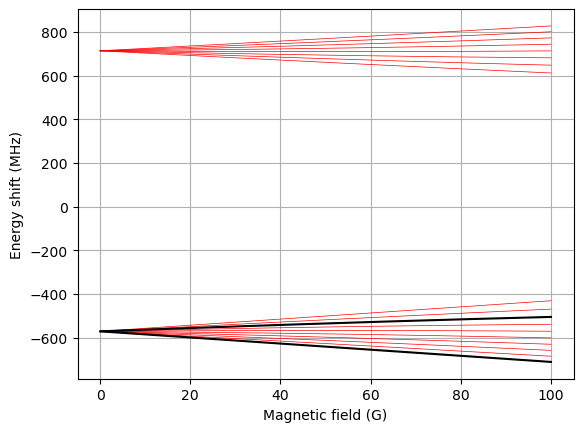

Frequency spacings (MHz), from low to high in state energy, at 0.1 G:
0.0312
0.0312
0.0312
0.0312
0.0312
0.0312
0.0312
0.0312
0.0312
1285.5396
0.0311
0.0311
0.0311
0.0311
0.0311
0.0311
0.0311
 
Field sensitivity of shift (MHz per G), from low to high in state energy, at 0.1 G:
-1.402
-1.091
-0.779
-0.468
-0.156
0.156
0.467
0.779
1.091
1.402
-1.089
-0.778
-0.466
-0.155
0.156
0.467
0.778
1.089
 
Field sensitivity of splitting, df81 by dB:
2.1810 MHz per G


In [11]:
# Zeeman calculator cell
B_start = 0
B_end = 100
B_main = 0.1 # G
num_B = 1000

# Careful what you type in here!
Ahf = K40Ahf_s12
Bhf = K40Bhf_s12
L = 0
S = 1/2
J = 1/2
I = K40I
gI = K40gI

zeeman_splitting_calculator(J, I, gI, L, S, B_main, B_start, B_end, num_B, Ahf, Bhf, 
                            plotting = True, highlight_HF_states = [1,8], plot_range = None, 
                            single_B_field_calc_mode = True, print_field_sensitivity_between = [1,8],
                            search_mode = False, splitting = 22.830, splitting_between_states = [1,8],
                            labeling_mode='none')

# <font size = 5>Asymptotic bound-state model (ABM) for Feshbach resonances</font>

## <font size=4> Theory (due to Tiecke) </font>

Here we quickly outline the recipe for this calculation. The Hamiltonian is that of a two-body system, in this case they are Na and K. There are two terms contributing to the total Hamiltonian: one due to the relative motion of the two atoms, and the other due to the Zeeman and hyperfine interaction of the atoms. 

The eigenstates of the first term, $H_\text{rel}$ consist of wavefunctions of bound states and continuum states. The bound states have binding energy $\epsilon^{S,l}_\nu$ are of the form $\ket{\psi_\nu^{S,l} (r)} \ket{Y^l_{m_l}}$, where $Y^l_{m_l}$ are spherical harmonics and $\nu$ denotes the vibrational level. In the ABM calculation, we need the bound-state energies $\epsilon_\nu^{S,l}$ as well as the Franck-Condon factors $\bra{\psi_\nu^{S,l} (r)} \ket{\psi_{\nu'}^{S',l} (r)} $. These are found from molecular potentials. As for the spin part, we let $\{ \ket{\sigma} \}$ label the spin states. 

The eigenvalue equation looks like $(H_\text{rel} + H_\text{int})  \ket{\psi_\nu^{S,l} (r)} \ket{Y^l_{m_l}} \ket{\sigma} = E_b\ket{\psi_\nu^{S,l} (r)} \ket{Y^l_{m_l}} \ket{\sigma}$. We would like to solve for $E_b$. 

Regarding $\{ \ket{\sigma} \}$, there are multiple options. There are two atoms with total spin $\bf{S}$, each with their own nuclear spin. The ABM spin basis is of the form $\{ \ket{S, M_S, m_{I,\text{Na}}, m_{I,\text{K}}}\}$. The Breit-Rabi basis has the form $\{ \ket{F_\text{Na}, m_{F,\text{Na}}, F_\text{K}, m_{F,\text{K}}}\}$.

Experimentally, we prepare the atomic mixture with a known $M_F = m_{F, \text{Na}} + m_{F, \text{K}}$. The total Hamiltonian not only preserves the orbital quantum number $l$, but also $M_F = M_S + m_{I, \text{Na}} + m_{I, \text{K}}$. As a result, we only need to enumerate ossible ABM states $\ket{\psi_\nu^{S,l}(r)} \ket{Y^l_{m_l}}\ket{\sigma}$ whose $M_F$ is equal to the $M_F$ of the entrace channel. This should greatly simplify the calculation. The eigenvalue equation above can thus be split into different $l$-sectors. 

$$ \epsilon^{S,l}_\nu  \delta_{\sigma\sigma'} \delta_{\nu\nu'}\delta_{ll'}\delta_{SS'} + \bra{\psi^{S',l}_{\nu'}} \ket{ \psi^{S,l}_\nu } \bra{\sigma'}H_\text{int} \ket{\sigma} = E_b \bra{\psi^{S',l}_{\nu'}} \ket{ \psi^{S,l}_\nu }  \delta_{\sigma\sigma'} \delta_{ll'}   $$

The calculation below is split into a few sections, in order of increasing complexity. In the first section, we look at the Standard ABM model where we don't consider the continuum. This calculation tells us where the Feshbach resonances are, but does not tell us the widths. In the second section, we look at the Dressed ABM model where we include the coupling between the resonant levels and the continuum. In the third section, we look at the open/closed channel contribution and apply our knowlegde to the case of NaK. 

1/ Standard ABM: Here we only solve for the $l=0$ sector. The free parameters are (1) the binding energies and (2) the nontrivial Franck-Condon factors. For our purpose, we only include the least-bound states of the $X^1\Sigma^+$ and $a^3\Sigma^+$ potentials. The binding energies can be found if we have a really good SE solver and a very well-known molecular potential. Typically, we don't have both unfortunately. However, we can estimate these binding energies from known scattering lengths and the Van der Waals' $C_6$ parameter. The Franck-Condon factor can also be estimated without knowing the full radial wavefunction. With these in hand, we can now solve:

(a) Find the threshold energy (a.k.a entrace channel energy): this is the just the sum of the Zeeman energies from individual atoms at a certain magnetic field.

(b) Find the closed-channel energy: To do with we simply diagonlize the Hamiltonian given above. To simplify the calculations, we may focus ourselves to only $s$-wave interactions, so we can set $l=0$. We also consider only two least-bound states of the singlet and triplet potentials, so we only need $\epsilon^{0,0}$ and $\epsilon^{1,0}$. This leaves only one relevant Franck-Condon factor. For our case of $^{23}\text{Na}$ and $^{40}\text{K}$, the spin sector has $8\times 18 = 144$ states. This could make the Hamiltonian quite large, but we can simply by consider the states with $M_F$ equal to $M_F$ of the entrance channel (since angular momentum is conserved). For the case of $\ket{1,1}$ and $\ket{9/2, -9/2}$, we have $M_F = 1 - 9/2 = -7/2$. There are only 12 such states. The final Hamiltonian is therefore only $12\times 12$. 

Some comments: The Feshbach resonances predicted by the standard ABM calculation are lower than the measured resonances. This is due to the inadequacies of the model which are amended by the dress ABM which takes into account continuum contribution. 

2/ Dressed ABM: Here we take into account the coupling between the resonant level and the continuum states. This inclusion not only shifts the Feshbach resonances predicted by the standard ABM model but also introduces resonance widths. 


## <font size=4> Getting least-bound bound-state energies from Van der Waals C6 and scattering length </font>

In [27]:
# numerov calculate for ABM
@jit(nopython=True, cache=True)
def numerov_backward_integration(r, gr, dr=1e-3):
    u = np.zeros(r.size)
    # integrate backward to get u[r_center_idx],...,u[r.size-1], overwriting u[r_center_idx]
    for j in np.linspace(r.size-1, 0, r.size):
        i = int(j)
        if i == r.size-1:
            u[i] = 0
        elif i == r.size-2:
            u[i] = -dr
        else:
            u[i] = 2*(1 - (5/12)*gr[i+1]*dr**2)*u[i+1] - (1+gr[i+2]*dr**2/12)*u[i+2]
            u[i] /= 1 + gr[i]*dr**2/12
    return u
@jit(nopython=True, cache=True)
def numerov_forward_integration(r, gr, u0, du0, dr=1e-3):
    u = np.zeros(r.size)
    # integrate forward to get u[r_center_idx],...,u[r.size-1], overwriting u[r_center_idx]
    for j in np.linspace(0, r.size-1, r.size):
        i = int(j)
        if i == 0:
            u[i] = u0
        elif i == 1:
            u[i] = u0 + du0 * dr 
        else:
            u[i] = 2*(1 - (5/12)*gr[i-1]*dr**2)*u[i-1] - (1+gr[i-2]*dr**2/12)*u[i-2]
            u[i] /= 1 + gr[i]*dr**2/12 
    return u

In [67]:
# Accumulated phase method to get bound-state energy from C6 and aScat
def bound_state_energy_MHz_from_C6_and_aScat(C6, aScat, a_in = 10, l = 0, species = 'Na40K', 
                                                potential_name = 'X1SigmaPlus', max_iter = 1000, dE_tol = 1e-4, verbose = False):
    if species == 'Na40K':
        mu = muNa40K*u/me
    hbar_ABM = 1
    # convert C6 in atomic units to SI:
    Eh = 4.35974394e-18
    C6 = (C6 * h_planck * 100 * c / Eh) * (a0 * 1e10)**(-6) 
    # initial guess for energy: something small
    En_first = 10*kB / (1e9 * Eh)
    k = np.sqrt(2*mu*En_first) / hbar_ABM

    if potential_name == 'X1SigmaPlus':
        N_osc = 10
        a_boundary = N_osc * 2*np.pi/k + aScat
        r_points = int((a_boundary - a_in)/(1e-1))

    elif potential_name == 'a3SigmaPlus':
        N_osc = 6
        a_boundary = N_osc * 2*np.pi/k + aScat
        r_points = int((a_boundary - a_in)/(0.125e-1))

    # now integrate inward
    r = np.linspace(a_in, a_boundary, r_points)
    Vr = -C6/r**6 + l*(l+1)*hbar_ABM**2/(2*mu*r**2)
    psi = numerov_backward_integration(r, gr = (+2*mu/hbar_ABM**2) * (En_first - Vr), dr = abs(r[1] - r[0]))

    psi_a_in = psi[0]
    psi_a_in_prime = (psi[0] - psi[1])/(r[0] - r[1])

    r_old = r
    psi_old = psi 

    # now use this wfn to get bound state by changing E until wfn decays properly to zero at a certain distance:
    a_boundary = 400 
    r_points = int((a_boundary - a_in)/1e-3)
    r = np.linspace(a_in, a_boundary, r_points)
    Vr = -C6/r**6 + l*(l+1)*hbar_ABM**2/(2*mu*r**2)
    En = -1e6  * h_planck / Eh # initial guess = -1 MHz
    dE = -10e6 * h_planck / Eh # initial correction = -10 MHz

    psi_end_new = 0
    iter = 0
    psi = np.zeros(r.size)
    while np.abs(dE) >= dE_tol * (h_planck/Eh) and iter <= max_iter:
        psi = numerov_forward_integration(r, gr = (+2*mu/hbar_ABM**2) * (En - Vr), u0 = psi_a_in, du0 = psi_a_in_prime, dr = abs(r[1] - r[0]))
        psi_end_old = psi_end_new
        psi_end_new = psi[-1]
        if psi_end_new * psi_end_old < 0:
            dE = -0.8*dE
        iter += 1
        En += dE
    bound_state_energy_MHz = En / (1e6 * h_planck / Eh)
    dE_MHz = dE / (1e6 * h_planck / Eh)
    psi = psi

    if verbose:
        if potential_name == 'X1SigmaPlus':
            plt.plot(r, psi)
            plt.plot(r_old, psi_old)
            plt.xlim([0,a_boundary/2])
            plt.ylim([2*min(psi),2*max(psi)])
        elif potential_name == 'a3SigmaPlus':
            plt.xlim([0,a_boundary/2])
            plt.plot(r, psi)
            plt.plot(r_old, psi_old)
            plt.ylim([min(psi_old)/50, max(psi_old)/50])
        print(psi_a_in)
        print(psi_a_in_prime)
        print('Last iteration:')
        print(iter)
        print('Last correction in MHz:')
        print(dE_MHz)
        print('Bound state energy in MHz:')
        print(bound_state_energy_MHz)

    return bound_state_energy_MHz

4.969462968661213
-5.2775976567558285
Last iteration:
210
Last correction in MHz:
-9.61963041904168e-12
Bound state energy in MHz:
-152.4677311921917


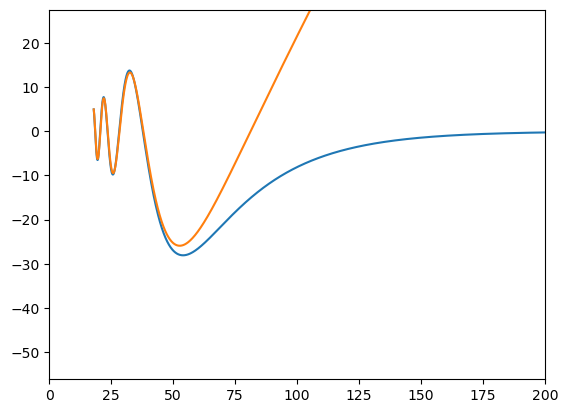

In [62]:
X1SP_least_bound_E_MHz = bound_state_energy_MHz_from_C6_and_aScat(1.1793e7, 69, a_in = 18, l=0,species='Na40K', 
                                                                    potential_name = 'X1SigmaPlus', max_iter = 1000, dE_tol = 1e-5, verbose = True)

26.228595788764505
-225.83486519662537
Last iteration:
358
Last correction in MHz:
-9.61963041904168e-12
Bound state energy in MHz:
-1678.401783645111


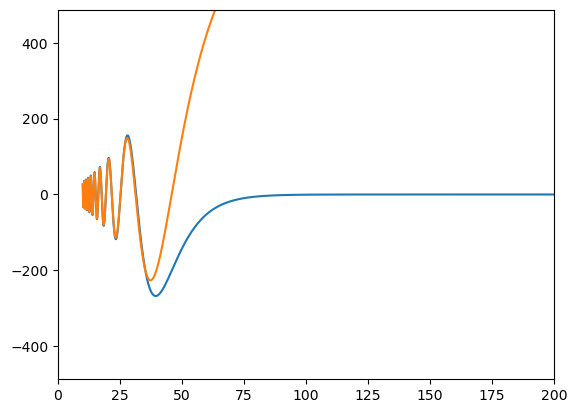

In [68]:
a3SP_least_bound_E_MHz = bound_state_energy_MHz_from_C6_and_aScat(1.1793e7, -830, a_in = 10, l=0,species='Na40K', 
                                                                    potential_name = 'a3SigmaPlus', max_iter = 1000, dE_tol = 1e-5, verbose=True)

## <font size=4> Standard ABM calculation for Na40K </font>

In [572]:
# helper functions
def calculate_threshold_energy_NaK(B_calc, Na_state_number, K_state_number, Na_Ahf, Na_Bhf, L_Na, S_Na, J_Na, K_Ahf, K_Bhf, L_K, S_K, J_K):
    threshold_energies = []*B_calc.size
    for b in B_calc:
        Na_energies_at_B_calc = zeeman_energy_calculator(J_Na,Na23I,Na23gI,L_Na,S_Na,b, Na_Ahf, Na_Bhf, labeling_mode = None)
        K_energies_at_B_calc  = zeeman_energy_calculator(J_K,K40I,K40gI,L_K,S_K,b, K_Ahf, K_Bhf, labeling_mode = None)
        threshold_energies.append(Na_energies_at_B_calc[Na_state_number] + K_energies_at_B_calc[K_state_number])
    return threshold_energies

def standard_ABM_spin_basis_Na40K(mF_Na, mF_K):
    # the ABM spin basis has the form {J, MJ, mI_Na, mI_K}
    # since L = 0, we have J = S = {0,1}
    mI_Na = np.linspace(-Na23I, Na23I, int(2*Na23I+1))
    mI_K = np.linspace(-K40I, K40I, int(2*K40I+1))
    ABM_spin_basis = []
    for J in [0,1]:
        mJ = np.linspace(-J, J, int(2*J+1))
        for mj in mJ:
            for mi_Na in mI_Na:
                for mi_K in mI_K:
                    if mi_Na + mi_K + mj == mF_Na + mF_K:
                        ABM_spin_basis.append([J, mj, mi_Na, mi_K])
    ABM_spin_basis = np.array(ABM_spin_basis)
    return ABM_spin_basis

def standard_ABM_product_basis_Na40K(mF_Na, mF_K):
    # the ABM product basis has the form {mJ_Na, mJ_K, mI_Na, mI_K}
    # since L = 0, we have J = S = {0,1}
    mI_Na = np.linspace(-Na23I, Na23I, int(2*Na23I+1))
    mI_K = np.linspace(-K40I, K40I, int(2*K40I+1))
    mJ_Na = np.linspace(-1/2, 1/2, int(2*1/2+1))
    mJ_K = np.linspace(-1/2, 1/2, int(2*1/2+1))
    ABM_product_basis = []
    for mj_Na in mJ_Na:
        for mj_K in mJ_K:
            for mi_Na in mI_Na:
                for mi_K in mI_K:
                    if mi_Na + mi_K + mj_Na + mj_K == mF_Na + mF_K:
                        ABM_product_basis.append([mj_Na, mj_K, mi_Na, mi_K])
    ABM_product_basis = np.array(ABM_product_basis)
    return ABM_product_basis

In [579]:
# diagonalize standard ABM Hamiltonian vs B and look for crossings with E_threshold
def standard_ABM_calculate_NaK(mF_Na, mF_K, singlet_E0 = -713, triplet_E0 = -425, FC= 0.979, B_fields=[0], y_plot_range = [-1950, 1550]):
    spin_basis =    standard_ABM_spin_basis_Na40K(mF_Na, mF_K)
    product_basis = standard_ABM_product_basis_Na40K(mF_Na, mF_K)
    list_of_freqs = []
    # first construct Clebsch-Gordan matrix to go from j1m1j2m2 to JM basis:
    CG_matrix = np.empty((len(spin_basis), len(spin_basis)))
    for p in range(len(product_basis)):
        mj_Na  = product_basis[p][0]
        mj_K   = product_basis[p][1]
        mi_Na  = product_basis[p][2]
        mi_K   = product_basis[p][3]
        for s in range(len(spin_basis)):
            J      = spin_basis[s][0]
            MJ     = spin_basis[s][1]
            mii_Na = spin_basis[s][2]
            mii_K  = spin_basis[s][3]
            CG_matrix[p,s] = int(mi_Na == mii_Na)*int(mi_K == mii_K)* clebsch_gordan(j_1=1/2, j_2=1/2, j_3=J, m_1=mj_Na, m_2=mj_K, m_3=MJ)
    for b in B_fields:
        # then calculate Hint matrix elements in {j1m1j2m2} basis:
        Hint_product_basis = np.empty((len(product_basis), len(product_basis)))
        for r in range(len(product_basis)):
            mj_Na = product_basis[r][0]
            mj_K  = product_basis[r][1]
            mi_Na = product_basis[r][2]
            mi_K  = product_basis[r][3]
            for c in range(len(product_basis)):
                mjj_Na = product_basis[c][0]
                mjj_K  = product_basis[c][1]
                mii_Na = product_basis[c][2]
                mii_K  = product_basis[c][3]
                H_int_Na = Na23Ahf_s12 * A_hfs(1/2, Na23I, mj_Na, mi_Na, mjj_Na, mii_Na) + mag(b, 1/2, 0, 1/2, mj_Na, mi_Na, mjj_Na, mii_Na, Na23gI)
                H_int_K  = K40Ahf_s12 * A_hfs(1/2, K40I, mj_K, mi_K, mjj_K, mii_K) + mag(b, 1/2, 0, 1/2, mj_K, mi_K, mjj_K, mii_K, K40gI)
                Hint_product_basis[r,c] = H_int_Na*int(mj_K == mjj_K)*int(mi_K==mii_K) + H_int_K*int(mj_Na == mjj_Na)*int(mi_Na==mii_Na)
        Hint_ABM_spin_basis = np.matmul(  np.matmul( np.conjugate(np.transpose(CG_matrix)) , Hint_product_basis), CG_matrix)

        # now use this result to get the full Hamiltonian
        H = np.empty((len(spin_basis), len(spin_basis)))
        for i in range(len(spin_basis)):
            for j in range(len(spin_basis)):    
                if spin_basis[i][0] == 0: # singlet
                    epsilon = singlet_E0*1e6
                elif spin_basis[i][0] == 1: # triplet 
                    epsilon = triplet_E0*1e6
                if spin_basis[i][0] == spin_basis[j][0]:
                    overlap = 1
                else:
                    overlap = FC
                H[i,j] = epsilon*int(i==j) + overlap * Hint_ABM_spin_basis[i][j]
        
        freqs, eigenvectors = np.linalg.eig(H)
        freqs = freqs * 1e-6
        list_of_freqs.append(freqs)

    list_of_freqs = np.array(list_of_freqs)
    list_of_freqs = np.sort(list_of_freqs, axis=1)  
    
    fig, ax = plt.subplots(figsize=(4, 6))
    if mF_Na == 1 and mF_K == -9/2:
        Na_state_number = 0
        K_state_number = 0
    threshold_energies = calculate_threshold_energy_NaK(B_calc=B_fields, Na_state_number=Na_state_number, K_state_number=K_state_number, 
                Na_Ahf = Na23Ahf_s12, Na_Bhf = Na23Bhf_s12, L_Na = 0, S_Na = 1/2, J_Na = 1/2,
                K_Ahf  = K40Ahf_s12, K_Bhf  = K40Bhf_s12, L_K  = 0, S_K  = 1/2, J_K = 1/2)
    threshold_energies = np.array(threshold_energies)
    ax.plot(B_fields, threshold_energies, color='k', linewidth=1) # with(out) zeroing Eth

    # get crossings between threshold energies and eigenvalues:
    freqs_minus_threshold = []*B_fields.size
    for s in range(len(spin_basis)):
        ax.plot(B_fields, list_of_freqs[:,s], linewidth = 1, color='red')  # with(out) zeroing Eth
        freqs_minus_threshold.append(list_of_freqs[:,s] - threshold_energies)
    ax.set_xlabel('Magnetic field (G)')
    ax.set_ylabel('Energy (MHz)')    

    freqs_minus_threshold = np.transpose(np.array(freqs_minus_threshold))
    resonance_positions = []
    for s in range(len(spin_basis)):
        for j in range(freqs_minus_threshold[:,s].size-1):
            if freqs_minus_threshold[j,s]*freqs_minus_threshold[j+1,s] <= 0:
                resonance_positions.append((B_fields[j] + B_fields[j+1])/2)
    resonance_positions = np.sort(np.array(resonance_positions))
    print('Resonance positions (G):')
    print(resonance_positions)

    # draw crossings on plot:
    if y_plot_range != None:
        for c in resonance_positions:
            ax.vlines(c, ymin = y_plot_range[0], ymax = y_plot_range[1], color = 'g', linestyle = 'dashed', linewidth=0.5)
        ax.set_ylim(y_plot_range)
    else:
        for c in resonance_positions:
            ax.vlines(c, ymin = np.amin(list_of_freqs), ymax = np.amax(list_of_freqs), color = 'g', linestyle = 'dashed', linewidth=0.5)
    plt.show() 

Resonance positions (G):
[73.62362362 79.22922923]


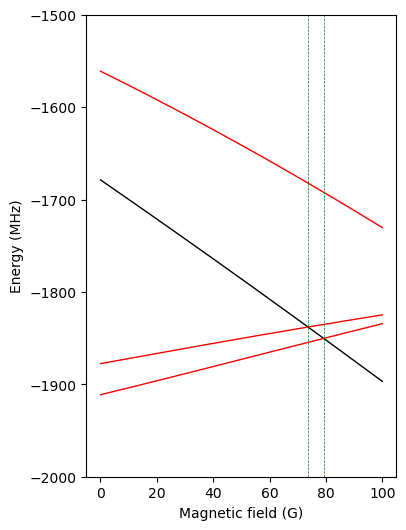

In [869]:
# standard ABM predicts Feshbach resonances for Na23 (1,1) + K40 (9/2,-9/2)
standard_ABM_calculate_NaK(1,-9/2, singlet_E0 = -210, triplet_E0 = -1654, FC= 0.499, B_fields = np.linspace(0,100,1000), y_plot_range = [-2000,-1500])

## <font size=4> Dressed ABM calculation for Na40K </font>

In [874]:
# for a B field value, return Hamiltonians and eigenvectors in ABM spin basis and product basis for NaK
def ABM_get_prod_basis_Hamiltonians_NaK(mF_Na, mF_K, singlet_E0 = -210, triplet_E0 = -1654, FC= 0.499, B_field = 0, 
                                                spin_basis=None, product_basis=None, CG_matrix=None):
    # calculate Hint matrix elements in {j1m1j2m2} basis:
    Hint_product_basis = np.empty((len(product_basis), len(product_basis)))
    for r in range(len(product_basis)):
        mj_Na = product_basis[r][0]
        mj_K  = product_basis[r][1]
        mi_Na = product_basis[r][2]
        mi_K  = product_basis[r][3]
        for c in range(len(product_basis)):
            mjj_Na = product_basis[c][0]
            mjj_K  = product_basis[c][1]
            mii_Na = product_basis[c][2]
            mii_K  = product_basis[c][3]
            H_int_Na = Na23Ahf_s12 * A_hfs(1/2, Na23I, mj_Na, mi_Na, mjj_Na, mii_Na) + mag(B_field, 1/2, 0, 1/2, mj_Na, mi_Na, mjj_Na, mii_Na, Na23gI)
            H_int_K  = K40Ahf_s12 * A_hfs(1/2, K40I, mj_K, mi_K, mjj_K, mii_K) + mag(B_field, 1/2, 0, 1/2, mj_K, mi_K, mjj_K, mii_K, K40gI)
            Hint_product_basis[r,c] = H_int_Na*int(mj_K == mjj_K)*int(mi_K==mii_K) + H_int_K*int(mj_Na == mjj_Na)*int(mi_Na == mii_Na)
    Hint_ABM_spin_basis = np.matmul(np.matmul( np.conjugate(np.transpose(CG_matrix)) , Hint_product_basis), CG_matrix)

    # now use this result to get the full Hamiltonian in the spin basis
    H_spin_basis = np.empty((len(spin_basis), len(spin_basis)))
    for i in range(len(spin_basis)):
        for j in range(len(spin_basis)):    
            if spin_basis[i][0] == 0: # singlet
                epsilon = singlet_E0*1e6
            elif spin_basis[i][0] == 1: # triplet 
                epsilon = triplet_E0*1e6
            if spin_basis[i][0] == spin_basis[j][0]:
                overlap = 1
            else:
                overlap = FC
            H_spin_basis[i,j] = epsilon*int(i==j) + overlap * Hint_ABM_spin_basis[i][j]
    H_spin_basis = H_spin_basis*1e-6 # converts to MHz
    
    # now subtract off the diagonal by E_threshold: define energies such that E_threshold = 0
    if mF_Na == 1 and mF_K == -9/2:
        Na_state_number = 0
        K_state_number = 0
    threshold_energies = calculate_threshold_energy_NaK(B_calc=np.array([B_field]), Na_state_number=Na_state_number, K_state_number=K_state_number, 
                Na_Ahf = Na23Ahf_s12, Na_Bhf = Na23Bhf_s12, L_Na= 0, S_Na = 1/2, J_Na = 1/2,
                K_Ahf  = K40Ahf_s12, K_Bhf  = K40Bhf_s12, L_K = 0, S_K  = 1/2, J_K = 1/2)
    E_threshold = np.eye(len(spin_basis)) * threshold_energies[0]

    # calculate Hamiltonians
    H_spin_basis = H_spin_basis - E_threshold    
    H_prod_basis = np.matmul(np.matmul(CG_matrix, H_spin_basis), np.conjugate(np.transpose(CG_matrix)))

    return Hint_product_basis, H_prod_basis

In [875]:
# Transforming from Breit-Rabi basis to ABM product basis, for every B, for NaK
def Breit_Rabi_to_ABM_product_matrix_NaK(mF_Na, mF_K, subspace_F_Na = 1, subspace_F_K = 9/2, B_field=0, Hint_product_basis=None):    
    # Construct H_internal in the Breit-Rabi basis:
    BR_freqs, BR_eigenvectors = np.linalg.eigh(Hint_product_basis)
    BR_to_ABM_prod_matrix = []
    for br in BR_eigenvectors:
        br = br / np.linalg.norm(br)
        BR_to_ABM_prod_matrix.append(br)
    BR_to_ABM_prod_matrix = np.array(BR_to_ABM_prod_matrix)
    return BR_to_ABM_prod_matrix

In [876]:
# for a given B field, calculate ABM Hamiltonian in BR basis for NaK
def ABM_BR_basis_Hamiltonian_NaK(mF_Na, mF_K, subspace_F_Na = 1, subspace_F_K = 9/2, B_field=0, spin_basis=spin_basis, product_basis=product_basis, CG_matrix=CG_matrix):
    Hint_product_basis, H_prod_basis = ABM_get_prod_basis_Hamiltonians_NaK(mF_Na = mF_Na, mF_K = mF_K, B_field = B_field, 
                                                                            spin_basis=spin_basis, product_basis=product_basis, CG_matrix=CG_matrix)
    # Matrix from BR and prod basis:
    BR_to_ABM_prod_matrix = Breit_Rabi_to_ABM_product_matrix_NaK(mF_Na,mF_K,subspace_F_Na,subspace_F_K, B_field=B_field, Hint_product_basis=Hint_product_basis)
    # calculate Hamiltonian
    ABM_BR_basis_H = np.matmul(np.matmul( np.conjugate(np.transpose(BR_to_ABM_prod_matrix)) , H_prod_basis), BR_to_ABM_prod_matrix)

    return ABM_BR_basis_H 

In [877]:
# dressed state energy function
def dressed_energy_function_NaK(E, *params):
    epsilon_Q, Delta_vs, E_vs = params
    return (-E) + epsilon_Q - (1/2)*Delta_vs**2 / ( E_vs * ( 1 + np.sqrt( -E / E_vs)))

In [892]:
# prepare parameters
mF_Na = 1
mF_K  = -9/2
F_Na  = 1
F_K   = 9/2
E_vs  = 2.292 
Delta_vs = 5.26
spin_basis_NaK    = standard_ABM_spin_basis_Na40K(mF_Na, mF_K)
product_basis_NaK = standard_ABM_product_basis_Na40K(mF_Na, mF_K)
# construct Clebsch-Gordan matrix to go from j1m1j2m2 to JM basis:
CG_matrix_NaK = np.empty((len(spin_basis_NaK), len(spin_basis_NaK)))
for p in range(len(product_basis)):
    for s in range(len(spin_basis)):
        mj_Na  = product_basis_NaK[p][0]
        mj_K   = product_basis_NaK[p][1]
        mi_Na  = product_basis_NaK[p][2]
        mi_K   = product_basis_NaK[p][3]
        J      = spin_basis_NaK[s][0]
        MJ     = spin_basis_NaK[s][1]
        mii_Na = spin_basis_NaK[s][2]
        mii_K  = spin_basis_NaK[s][3]
        CG_matrix_NaK[p,s] = int(mi_Na == mii_Na)*int(mi_K == mii_K)* clebsch_gordan(j_1=1/2, j_2=1/2, j_3=J, m_1=mj_Na, m_2=mj_K, m_3=MJ)

In [893]:
# dressed ABM with virtual state
B_fields = np.linspace(0.001,300,500)
epsilon_Q = []
epsilon_P = []
list_of_freqs = []
list_of_dressed_energies = []
list_of_kappas = []
neg_eQ = 0
for b in B_fields:
    H_BR = ABM_BR_basis_Hamiltonian_NaK(mF_Na,mF_K, F_Na, F_K, B_field=b, spin_basis=spin_basis_NaK, product_basis=product_basis_NaK, CG_matrix=CG_matrix_NaK)
    # get epsilon_P
    H_PP = H_BR[0,0]
    epsilon_P.append(H_PP)
    H_QQ = H_BR[1:,1:]
    # get epsilon_Q
    Q_freqs, Q_eigenvectors = np.linalg.eigh(H_QQ)
    epsilon_Q.append(Q_freqs)
    # standard ABM eigs
    freqs, eigenvectors = np.linalg.eigh(H_BR)
    list_of_freqs.append(freqs)
    # get K's 
    Ks = H_BR[0,1:]
    list_of_kappas.append(Ks)
    # solve for dressed energies: only calculate dressed_energies for eQ's which cross Eth = 0
    if b == min(B_fields):
        for f in Q_freqs:
            if f <= 0:
                neg_eQ += 1
    dressed_energies = []
    for q in range(len(Q_freqs)):
        if Q_freqs[q] < 0:
            roots = fsolve(dressed_energy_function_NaK, Q_freqs[q], args = (Q_freqs[q], Delta_vs, E_vs))
        else:
            roots = fsolve(dressed_energy_function_NaK, -Q_freqs[q], args = (Q_freqs[q], Delta_vs, E_vs))
        # hacky solution: dressed_energy is increasing. Only apply this after Q_freqs has crossed 0:
        r = min(roots)
        if Q_freqs[q] > 0:
            if len(list_of_dressed_energies) > 0:
                if r < list_of_dressed_energies[-1][q]:
                    r = 0
        if q >= neg_eQ:
            r = 0
        dressed_energies.append(r) # molecular energy must be < 0
    list_of_dressed_energies.append(dressed_energies)

epsilon_P = np.array(epsilon_P)
epsilon_Q = np.array(epsilon_Q)
list_of_freqs = np.array(list_of_freqs)
list_of_dressed_energies = np.array(list_of_dressed_energies)
list_of_kappas = np.array(list_of_kappas)

FB resonances (G):
[76.0528507  80.86245391]
Uncoupled eQ crossings (G):
[74.8504499  79.66005311]


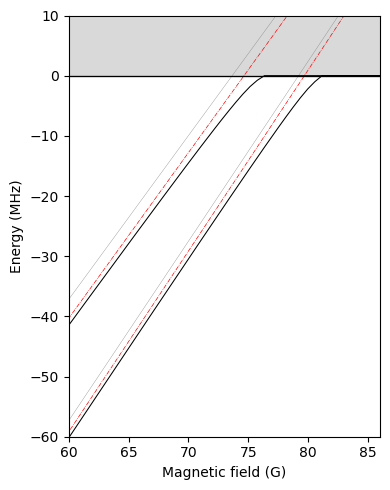

In [894]:
# NaK results, zoomed in near FB resonance
# plot standard ABM results, with E_threshold zeroed
fig, ax = plt.subplots(figsize=(4,5))

for i in range(list_of_freqs.shape[1]):
    ax.plot(B_fields, list_of_freqs[:,i],linewidth=0.25,color='gray')
# plot epsilon_P
ax.plot(B_fields, epsilon_P, color='blue',linewidth=0.5,linestyle='-.')
# plot epsilon Q
for i in range(epsilon_Q.shape[1]):
    ax.plot(B_fields, epsilon_Q[:,i],color='red',linewidth=0.5,linestyle='-.')
# plot threshold
ax.hlines(0, xmin=min(B_fields), xmax=max(B_fields),color='black',linewidth=0.5)
# fill continuum
ax.fill_between(B_fields, y1=0, y2=100, alpha=0.15,color='black')
# plot dressed_energies:
for i in range(list_of_dressed_energies.shape[1]):
    ax.plot(B_fields, list_of_dressed_energies[:,i],linewidth=0.75,color='black')

# get FB resonances from finding B for which dressed_energy = 0
FB_resonances = []
bare_eQ_crossings = []
for i in range(epsilon_Q.shape[1]):
    for j in range(epsilon_Q.shape[0]-1):
        if list_of_dressed_energies[j,i] * list_of_dressed_energies[j+1,i] <= 0 and (list_of_dressed_energies[j,i] + list_of_dressed_energies[j+1,i]) != 0:
            FB_resonances.append((B_fields[j] + B_fields[j+1])/2)
        if epsilon_Q[j,i] * epsilon_Q[j+1,i] <= 0:
            bare_eQ_crossings.append((B_fields[j] + B_fields[j+1])/2)

res_idx           = np.argsort(np.array(FB_resonances))
FB_resonances     = np.array(FB_resonances)[res_idx]
bare_eQ_crossings = np.array(bare_eQ_crossings)[res_idx]
print('FB resonances (G):')
print(FB_resonances)
print('Uncoupled eQ crossings (G):')
print(bare_eQ_crossings)

ax.set_xlabel('Magnetic field (G)')
ax.set_ylabel('Energy (MHz)')

# zoomed in
ax.set_ylim([-60,10])
ax.set_xlim([60,86])

plt.tight_layout()
plt.show()

FB resonances (G):
[76.0528507  80.86245391]
Uncoupled eQ crossings (G):
[74.8504499  79.66005311]


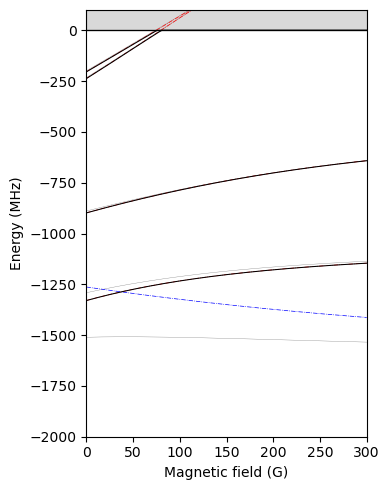

In [895]:
# NaK results, zoomed out to see dressed-state energies
# plot standard ABM results, with E_threshold zeroed
fig, ax = plt.subplots(figsize=(4,5))

for i in range(list_of_freqs.shape[1]):
    ax.plot(B_fields, list_of_freqs[:,i],linewidth=0.25,color='gray')
# plot epsilon_P
ax.plot(B_fields, epsilon_P, color='blue',linewidth=0.5,linestyle='-.')
# plot epsilon Q
for i in range(epsilon_Q.shape[1]):
    ax.plot(B_fields, epsilon_Q[:,i],color='red',linewidth=0.5,linestyle='-.')
# plot threshold
ax.hlines(0, xmin=min(B_fields), xmax=max(B_fields),color='black',linewidth=0.5)
# fill continuum
ax.fill_between(B_fields, y1=0, y2=100, alpha=0.15,color='black')
# plot dressed_energies:
for i in range(list_of_dressed_energies.shape[1]):
    ax.plot(B_fields, list_of_dressed_energies[:,i],linewidth=0.75,color='black')

# get FB resonances from finding B for which dressed_energy = 0
FB_resonances = []
bare_eQ_crossings = []
for i in range(epsilon_Q.shape[1]):
    for j in range(epsilon_Q.shape[0]-1):
        if list_of_dressed_energies[j,i] * list_of_dressed_energies[j+1,i] <= 0 and (list_of_dressed_energies[j,i] + list_of_dressed_energies[j+1,i]) != 0:
            FB_resonances.append((B_fields[j] + B_fields[j+1])/2)
        if epsilon_Q[j,i] * epsilon_Q[j+1,i] <= 0:
            bare_eQ_crossings.append((B_fields[j] + B_fields[j+1])/2)

res_idx           = np.argsort(np.array(FB_resonances))
FB_resonances     = np.array(FB_resonances)[res_idx]
bare_eQ_crossings = np.array(bare_eQ_crossings)[res_idx]
print('FB resonances (G):')
print(FB_resonances)
print('Uncoupled eQ crossings (G):')
print(bare_eQ_crossings)

ax.set_xlabel('Magnetic field (G)')
ax.set_ylabel('Energy (MHz)')

# zoomed in
ax.set_ylim([-2000,100])
ax.set_xlim([0,max(B_fields)])

plt.tight_layout()
plt.show()

## <font size=4> Closed/Open channel fraction from dressed ABM for NaK</font>

## <font size=3> [BONUS] Standard ABM calculation for Li40K </font>

In [5]:
# helper functions
def calculate_threshold_energy_LiK(B_calc, Li_state_number, K_state_number, Li_Ahf, Li_Bhf, L_Li, S_Li, J_Li, K_Ahf, K_Bhf, L_K, S_K, J_K):
    threshold_energies = []*B_calc.size
    for b in B_calc:
        Li_energies_at_B_calc = zeeman_energy_calculator(J_Li,Li6I,Li6gI,L_Li,S_Li,b, Li_Ahf, Li_Bhf, labeling_mode = None)
        K_energies_at_B_calc  = zeeman_energy_calculator(J_K,K40I,K40gI,L_K,S_K,b, K_Ahf, K_Bhf, labeling_mode = None)
        threshold_energies.append(Li_energies_at_B_calc[Li_state_number] + K_energies_at_B_calc[K_state_number])
    return threshold_energies

def standard_ABM_spin_basis_Li40K(mF_Li, mF_K):
    # the ABM spin basis has the form {J, MJ, mI_Li, mI_K}
    # since L = 0, we have J = S = {0,1}
    mI_Li = np.linspace(-Li6I, Li6I, int(2*Li6I+1))
    mI_K = np.linspace(-K40I, K40I, int(2*K40I+1))
    ABM_spin_basis = []
    for J in [0,1]:
        mJ = np.linspace(-J, J, int(2*J+1))
        for mj in mJ:
            for mi_Li in mI_Li:
                for mi_K in mI_K:
                    if mi_Li + mi_K + mj == mF_Li + mF_K:
                        ABM_spin_basis.append([J, mj, mi_Li, mi_K])
    ABM_spin_basis = np.array(ABM_spin_basis)
    return ABM_spin_basis

def standard_ABM_product_basis_Li40K(mF_Li, mF_K):
    # the ABM product basis has the form {mJ_Li, mJ_K, mI_Li, mI_K}
    # since L = 0, we have J = S = {0,1}
    mI_Li = np.linspace(-Li6I, Li6I, int(2*Li6I+1))
    mI_K = np.linspace(-K40I, K40I, int(2*K40I+1))
    mJ_Li = np.linspace(-1/2, 1/2, int(2*1/2+1))
    mJ_K = np.linspace(-1/2, 1/2, int(2*1/2+1))
    ABM_product_basis = []
    for mj_Li in mJ_Li:
        for mj_K in mJ_K:
            for mi_Li in mI_Li:
                for mi_K in mI_K:
                    if mi_Li + mi_K + mj_Li + mj_K == mF_Li + mF_K:
                        ABM_product_basis.append([mj_Li, mj_K, mi_Li, mi_K])
    ABM_product_basis = np.array(ABM_product_basis)
    return ABM_product_basis

In [69]:
# diagonalize standard ABM Hamiltonian vs B and look for crossings with E_threshold
def standard_ABM_calculate_LiK(mF_Li, mF_K, singlet_E0 = -713, triplet_E0 = -425, FC= 0.979, B_fields=[0], y_plot_range = [-1950, 1550]):
    spin_basis =    standard_ABM_spin_basis_Li40K(mF_Li, mF_K)
    product_basis = standard_ABM_product_basis_Li40K(mF_Li, mF_K)
    list_of_freqs = []
    # first construct Clebsch-Gordan matrix to go from j1m1j2m2 to JM basis:
    CG_matrix = np.empty((len(spin_basis), len(spin_basis)))
    for p in range(len(product_basis)):
        mj_Li  = product_basis[p][0]
        mj_K   = product_basis[p][1]
        mi_Li  = product_basis[p][2]
        mi_K   = product_basis[p][3]
        for s in range(len(spin_basis)):
            J      = spin_basis[s][0]
            MJ     = spin_basis[s][1]
            mii_Li = spin_basis[s][2]
            mii_K  = spin_basis[s][3]
            CG_matrix[p,s] = int(mi_Li == mii_Li)*int(mi_K == mii_K)* clebsch_gordan(j_1=1/2, j_2=1/2, j_3=J, m_1=mj_Li, m_2=mj_K, m_3=MJ)
    for b in B_fields:
        # then calculate Hint matrix elements in {j1m1j2m2} basis:
        Hint_product_basis = np.empty((len(product_basis), len(product_basis)))
        for r in range(len(product_basis)):
            mj_Li = product_basis[r][0]
            mj_K  = product_basis[r][1]
            mi_Li = product_basis[r][2]
            mi_K  = product_basis[r][3]
            for c in range(len(product_basis)):
                mjj_Li = product_basis[c][0]
                mjj_K  = product_basis[c][1]
                mii_Li = product_basis[c][2]
                mii_K  = product_basis[c][3]
                H_int_Li = Li6Ahf_s12 * A_hfs(1/2, Li6I, mj_Li, mi_Li, mjj_Li, mii_Li) + mag(b, 1/2, 0, 1/2, mj_Li, mi_Li, mjj_Li, mii_Li, Li6gI)
                H_int_K  = K40Ahf_s12 * A_hfs(1/2, K40I, mj_K, mi_K, mjj_K, mii_K) + mag(b, 1/2, 0, 1/2, mj_K, mi_K, mjj_K, mii_K, K40gI)
                Hint_product_basis[r,c] = H_int_Li*int(mj_K == mjj_K)*int(mi_K==mii_K) + H_int_K*int(mj_Li == mjj_Li)*int(mi_Li==mii_Li)
        Hint_ABM_spin_basis = np.matmul(  np.matmul( np.conjugate(np.transpose(CG_matrix)) , Hint_product_basis), CG_matrix)

        # now use this result to get the full Hamiltonian
        H = np.empty((len(spin_basis), len(spin_basis)))
        for i in range(len(spin_basis)):
            for j in range(len(spin_basis)):    
                if spin_basis[i][0] == 0: # singlet
                    epsilon = singlet_E0*1e6
                elif spin_basis[i][0] == 1: # triplet 
                    epsilon = triplet_E0*1e6
                if spin_basis[i][0] == spin_basis[j][0]:
                    overlap = 1
                else:
                    overlap = FC
                H[i,j] = epsilon*int(i==j) + overlap * Hint_ABM_spin_basis[i][j]
        
        freqs, eigenvectors = np.linalg.eig(H)
        freqs = freqs * 1e-6
        list_of_freqs.append(freqs)

    list_of_freqs = np.array(list_of_freqs)
    list_of_freqs = np.sort(list_of_freqs, axis=1)  
    
    fig, ax = plt.subplots(figsize=(4, 6))
    if mF_Li == 1/2 and mF_K == -7/2:
        Li_state_number = 0
        K_state_number = 1
    threshold_energies = calculate_threshold_energy_LiK(B_calc=B_fields, Li_state_number=Li_state_number, K_state_number=K_state_number, 
                Li_Ahf = Li6Ahf_s12, Li_Bhf = Li6Bhf_s12, L_Li = 0, S_Li = 1/2, J_Li = 1/2,
                K_Ahf  = K40Ahf_s12, K_Bhf  = K40Bhf_s12, L_K  = 0, S_K  = 1/2, J_K = 1/2)
    threshold_energies = np.array(threshold_energies)
    ax.plot(B_fields, threshold_energies, color='k', linewidth=1) # with(out) zeroing Eth

    # get crossings between threshold energies and eigenvalues:
    freqs_minus_threshold = []*B_fields.size
    for s in range(len(spin_basis)):
        ax.plot(B_fields, list_of_freqs[:,s], linewidth = 1, color='red')  # with(out) zeroing Eth
        freqs_minus_threshold.append(list_of_freqs[:,s] - threshold_energies)
    ax.set_xlabel('Magnetic field (G)')
    ax.set_ylabel('Energy (MHz)')    

    freqs_minus_threshold = np.transpose(np.array(freqs_minus_threshold))
    resonance_positions = []
    for s in range(len(spin_basis)):
        for j in range(freqs_minus_threshold[:,s].size-1):
            if freqs_minus_threshold[j,s]*freqs_minus_threshold[j+1,s] <= 0:
                resonance_positions.append((B_fields[j] + B_fields[j+1])/2)
    resonance_positions = np.sort(np.array(resonance_positions))
    print('Resonance positions (G):')
    print(resonance_positions)

    # draw crossings on plot:
    if y_plot_range != None:
        for c in resonance_positions:
            ax.vlines(c, ymin = y_plot_range[0], ymax = y_plot_range[1], color = 'g', linestyle = 'dashed', linewidth=0.5)
        ax.set_ylim(y_plot_range)
    else:
        for c in resonance_positions:
            ax.vlines(c, ymin = np.amin(list_of_freqs), ymax = np.amax(list_of_freqs), color = 'g', linestyle = 'dashed', linewidth=0.5)
    plt.show() 

    # print out values at 0 field, to check:
    print(list_of_freqs[0,:])

Resonance positions (G):
[148.98989899 154.04040404 164.14141414]


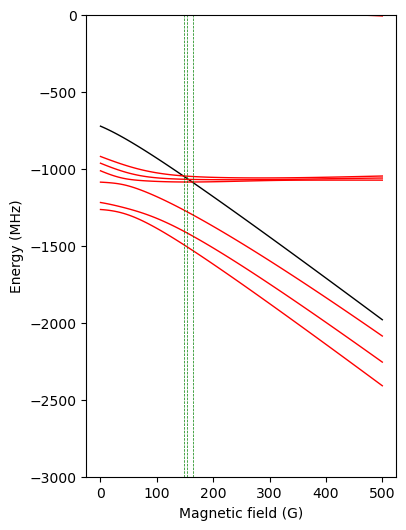

[-1264.786042   -1219.29343335 -1087.18778507 -1013.34474504
  -964.12629582  -920.39322765    37.97910571    70.11526396
   237.31610181   308.11689773   343.40115136]


In [51]:
# standard ABM predicts Feshbach resonances for Li6 (1/2,1/2) + K40 (9/2,-7/2)
standard_ABM_calculate_LiK(1/2,-7/2, singlet_E0 = -713, triplet_E0 = -425, FC= 0.979, B_fields = np.linspace(0,500,100), y_plot_range = [-3000,0])

## <font size=3> [BONUS] Dressed ABM calculation for Li40K </font>

In [537]:
# for a B field value, return Hamiltonians and eigenvectors in ABM spin basis and product basis for LiK
def ABM_get_prod_basis_Hamiltonians_LiK(mF_Li, mF_K, singlet_E0 = -713, triplet_E0 = -425, FC= 1.0, B_field = 0, 
                                                spin_basis=None, product_basis=None, CG_matrix=None):
    # calculate Hint matrix elements in {j1m1j2m2} basis:
    Hint_product_basis = np.empty((len(product_basis), len(product_basis)))
    for r in range(len(product_basis)):
        mj_Li = product_basis[r][0]
        mj_K  = product_basis[r][1]
        mi_Li = product_basis[r][2]
        mi_K  = product_basis[r][3]
        for c in range(len(product_basis)):
            mjj_Li = product_basis[c][0]
            mjj_K  = product_basis[c][1]
            mii_Li = product_basis[c][2]
            mii_K  = product_basis[c][3]
            H_int_Li = Li6Ahf_s12 * A_hfs(1/2, Li6I, mj_Li, mi_Li, mjj_Li, mii_Li) + mag(B_field, 1/2, 0, 1/2, mj_Li, mi_Li, mjj_Li, mii_Li, Li6gI)
            H_int_K  = K40Ahf_s12 * A_hfs(1/2, K40I, mj_K, mi_K, mjj_K, mii_K) + mag(B_field, 1/2, 0, 1/2, mj_K, mi_K, mjj_K, mii_K, K40gI)
            Hint_product_basis[r,c] = H_int_Li*int(mj_K == mjj_K)*int(mi_K==mii_K) + H_int_K*int(mj_Li == mjj_Li)*int(mi_Li==mii_Li)
    Hint_ABM_spin_basis = np.matmul(np.matmul( np.conjugate(np.transpose(CG_matrix)) , Hint_product_basis), CG_matrix)

    # now use this result to get the full Hamiltonian in the spin basis
    H_spin_basis = np.empty((len(spin_basis), len(spin_basis)))
    for i in range(len(spin_basis)):
        for j in range(len(spin_basis)):    
            if spin_basis[i][0] == 0: # singlet
                epsilon = singlet_E0*1e6
            elif spin_basis[i][0] == 1: # triplet 
                epsilon = triplet_E0*1e6
            if spin_basis[i][0] == spin_basis[j][0]:
                overlap = 1
            else:
                overlap = FC
            H_spin_basis[i,j] = epsilon*int(i==j) + overlap * Hint_ABM_spin_basis[i][j]
    H_spin_basis = H_spin_basis*1e-6 # converts to MHz
    
    # now subtract off the diagonal by E_threshold: define energies such that E_threshold = 0
    if mF_Li == 1/2 and mF_K == -7/2:
        Li_state_number = 0
        K_state_number = 1
    threshold_energies = calculate_threshold_energy_LiK(B_calc=np.array([B_field]), Li_state_number=Li_state_number, K_state_number=K_state_number, 
                Li_Ahf = Li6Ahf_s12, Li_Bhf = Li6Bhf_s12, L_Li= 0, S_Li = 1/2, J_Li = 1/2,
                K_Ahf  = K40Ahf_s12, K_Bhf  = K40Bhf_s12, L_K = 0, S_K  = 1/2, J_K = 1/2)
    E_threshold = np.eye(len(spin_basis)) * threshold_energies[0]

    # calculate Hamiltonians
    H_spin_basis = H_spin_basis - E_threshold    
    H_prod_basis = np.matmul(np.matmul(CG_matrix, H_spin_basis), np.conjugate(np.transpose(CG_matrix)))

    return Hint_product_basis, H_prod_basis

In [327]:
# Transforming from Breit-Rabi basis to ABM product basis, for every B, for LiK
def Breit_Rabi_to_ABM_product_matrix_LiK(mF_Li, mF_K, subspace_F_Li = 1/2, subspace_F_K = 9/2, B_field=0, Hint_product_basis=None):    
    # Construct H_internal in the Breit-Rabi basis:
    BR_freqs, BR_eigenvectors = np.linalg.eigh(Hint_product_basis)
    BR_to_ABM_prod_matrix = []
    for br in BR_eigenvectors:
        br = br / np.linalg.norm(br)
        BR_to_ABM_prod_matrix.append(br)
    BR_to_ABM_prod_matrix = np.array(BR_to_ABM_prod_matrix)
    return BR_to_ABM_prod_matrix

In [307]:
# for a given B field, calculate ABM Hamiltonian in BR basis for LiK
def ABM_BR_basis_Hamiltonian_LiK(mF_Li, mF_K, subspace_F_Li = 1/2, subspace_F_K = 9/2, B_field=0, spin_basis=spin_basis, product_basis=product_basis, CG_matrix=CG_matrix):
    Hint_product_basis, H_prod_basis = ABM_get_prod_basis_Hamiltonians_LiK(mF_Li = mF_Li, mF_K = mF_K, B_field = B_field, 
                                                                            spin_basis=spin_basis, product_basis=product_basis, CG_matrix=CG_matrix)
    # Matrix from BR and prod basis:
    BR_to_ABM_prod_matrix = Breit_Rabi_to_ABM_product_matrix_LiK(mF_Li,mF_K,subspace_F_Li,subspace_F_K, B_field=B_field, Hint_product_basis=Hint_product_basis)
    # calculate Hamiltonian
    ABM_BR_basis_H = np.matmul(np.matmul( np.conjugate(np.transpose(BR_to_ABM_prod_matrix)) , H_prod_basis), BR_to_ABM_prod_matrix)

    return ABM_BR_basis_H 

In [397]:
# dressed state energy function
def dressed_energy_function(E, *params):
    epsilon_P, epsilon_Q, Kappa = params
    return -np.sqrt(-epsilon_P)*(-E)**(3/2) + (-epsilon_P)*(-E)  - np.sqrt(-epsilon_P)*epsilon_Q*np.sqrt(-E) - epsilon_P*epsilon_Q + (1/2)*Kappa**2

In [897]:
# prepare parameters
mF_Li =  1/2
mF_K  = -7/2
F_Li  = 1/2
F_K   = 9/2
spin_basis_LiK    = standard_ABM_spin_basis_Li40K(mF_Li, mF_K)
product_basis_LiK = standard_ABM_product_basis_Li40K(mF_Li, mF_K)
# first construct Clebsch-Gordan matrix to go from j1m1j2m2 to JM basis:
CG_matrix_LiK = np.empty((len(spin_basis_LiK), len(spin_basis_LiK)))
for p in range(len(product_basis_LiK)):
    for s in range(len(spin_basis_LiK)):
        mj_Li  = product_basis_LiK[p][0]
        mj_K   = product_basis_LiK[p][1]
        mi_Li  = product_basis_LiK[p][2]
        mi_K   = product_basis_LiK[p][3]
        J      = spin_basis_LiK[s][0]
        MJ     = spin_basis_LiK[s][1]
        mii_Li = spin_basis_LiK[s][2]
        mii_K  = spin_basis_LiK[s][3]
        CG_matrix_LiK[p,s] = int(mi_Li == mii_Li)*int(mi_K == mii_K)* clebsch_gordan(j_1=1/2, j_2=1/2, j_3=J, m_1=mj_Li, m_2=mj_K, m_3=MJ)

FB resonances (G):
[149.00016989 160.20386712 165.90574875]
Uncoupled eQ crossings (G):
[149.60036796 160.40393314 165.90574875]
Widths (G):
[0.18165402 0.06059199 0.        ]


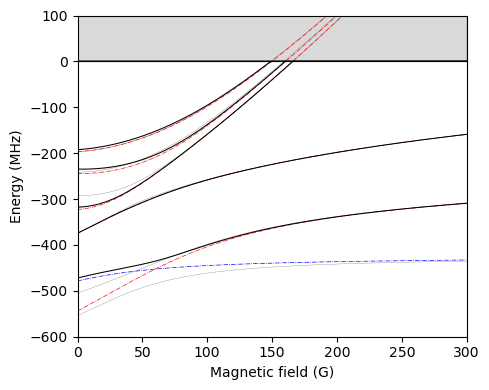

In [898]:
# dressed ABM without virtual state
B_fields = np.linspace(0.001,300,3000)
epsilon_Q = []
epsilon_P = []
list_of_freqs = []
list_of_dressed_energies = []
list_of_kappas = []
for b in B_fields:
    H_BR = ABM_BR_basis_Hamiltonian_LiK(mF_Li,mF_K, F_Li, F_K, B_field=b, spin_basis=spin_basis_LiK, product_basis=product_basis_LiK, CG_matrix=CG_matrix_LiK)
    # get epsilon_P
    H_PP = H_BR[0,0]
    epsilon_P.append(H_PP)
    H_QQ = H_BR[1:,1:]
    # get epsilon_Q
    Q_freqs, Q_eigenvectors = np.linalg.eigh(H_QQ)
    epsilon_Q.append(Q_freqs)
    # standard ABM eigs
    freqs, eigenvectors = np.linalg.eigh(H_BR)
    list_of_freqs.append(freqs)
    # get K's 
    Ks = H_BR[0,1:]
    list_of_kappas.append(Ks)
    # solve for dressed energies
    dressed_energies = []
    for q in range(len(Q_freqs)):
        roots = fsolve(dressed_energy_function, max(Q_freqs[q], 0.96*H_PP), args = (H_PP, Q_freqs[q], Ks[q]))
        dressed_energies.append(min(0,roots[0])) # molecular energy must be < 0
    list_of_dressed_energies.append(dressed_energies)

epsilon_P = np.array(epsilon_P)
epsilon_Q = np.array(epsilon_Q)
list_of_freqs = np.array(list_of_freqs)
list_of_dressed_energies = np.array(list_of_dressed_energies)
list_of_kappas = np.array(list_of_kappas)

# plot standard ABM results, with E_threshold zeroed
fig, ax = plt.subplots(figsize=(5,4))

for i in range(list_of_freqs.shape[1]):
    ax.plot(B_fields, list_of_freqs[:,i],linewidth=0.25,color='gray')
# plot epsilon_P
ax.plot(B_fields, epsilon_P, color='blue',linewidth=0.5,linestyle='-.')
# plot epsilon Q
for i in range(epsilon_Q.shape[1]):
    ax.plot(B_fields, epsilon_Q[:,i],color='red',linewidth=0.5,linestyle='-.')
# plot threshold
ax.hlines(0, xmin=min(B_fields), xmax=max(B_fields),color='black',linewidth=0.5)
# fill continuum
ax.fill_between(B_fields, y1=0, y2=100, alpha=0.15,color='black')
# plot dressed_energies:
for i in range(list_of_dressed_energies.shape[1]):
    ax.plot(B_fields, list_of_dressed_energies[:,i],linewidth=0.75,color='black')

# get FB resonances from finding B for which eQ*eP-K^2/2=0, i.e. dressed_energy = 0
FB_resonances = []
bare_eQ_crossings = []
eP_at_resonance = []
for i in range(epsilon_Q.shape[1]):
    for j in range(epsilon_Q.shape[0]-1):
        f1 = epsilon_Q[j,i]*epsilon_P[j] - list_of_kappas[j,i]**2/2
        f2 = epsilon_Q[j+1,i]*epsilon_P[j+1] - list_of_kappas[j+1,i]**2/2
        if f1*f2 <= 0:
            FB_resonances.append((B_fields[j] + B_fields[j+1])/2)
            eP_at_resonance.append(epsilon_P[j])
        if epsilon_Q[j,i] * epsilon_Q[j+1,i] <= 0:
            bare_eQ_crossings.append((B_fields[j] + B_fields[j+1])/2)
res_idx           = np.argsort(np.array(FB_resonances))
FB_resonances     = np.array(FB_resonances)[res_idx]
bare_eQ_crossings = np.array(bare_eQ_crossings)[res_idx]
eP_at_resonance   = np.array(eP_at_resonance)[res_idx]
print('FB resonances (G):')
print(FB_resonances)
print('Uncoupled eQ crossings (G):')
print(bare_eQ_crossings)

# calculate widths
# note: widths not quite right since we don't know precisely the fit results from Tiecke 2010
widths = []
muLiK  = (mLi6*mK40)/(mLi6 + mK40)
Eh     = 4.35974e-18 # J
C6     = 2322 * Eh * (a0**6)
a_P_bg = ((1/2) * (2*muLiK*C6/(hbar**2))**(1/4)) / a0 
for i in range(len(FB_resonances)):
    a_P  = (1/np.sqrt(-eP_at_resonance[i]*2*mu/hbar**2) ) /a0 
    a_bg = a_P + a_P_bg
    delta_B = abs((a_P/a_bg) * (FB_resonances[i] - bare_eQ_crossings[i]))
    widths.append(delta_B)
widths = np.array(widths)
print('Widths (G):')
print(widths)

ax.set_xlabel('Magnetic field (G)')
ax.set_ylabel('Energy (MHz)')

# zoomed in
# ax.set_ylim([-70,10])
# ax.set_xlim([140, 170])

# zoomed out 
ax.set_ylim([-600,100])
ax.set_xlim([0, max(B_fields)])

plt.tight_layout()
plt.show()

# <font size = 5>NaK Feshbach molecules</font>

Here we compute a rough curve for the binding energy of weakly-bound Feshbach molecules in the vicinity of a Feshbach resonance.

In [899]:
# plot binding energy vs magnetic field (naive model)
# a more precise 1-parameter model is given by Eqn (2) of CHW's paper
def Eb(B, width_FB = [5.8, 9.55],B_FB = [78.35, 89.8]):
    a_mean = 51*a0
    a_bg = -690 * a0
    fb_factor = 1
    for i in range(len(B_FB)):
        fb_factor *= (1+width_FB[i]/(B-B_FB[i]))
    a = a_bg*fb_factor
    Eb = hbar**2 / (2*muNa40K*u*(a - a_mean)**2)
    return Eb/(hbar*2*np.pi)

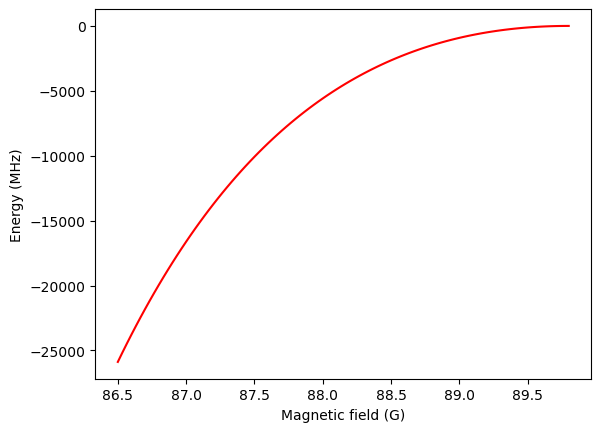

In [902]:
B = np.linspace(86.5,89.8,100)
Eb_array = Eb(B)
plt.plot(B,-Eb_array, color='red')
plt.xlabel('Magnetic field (G)')
plt.ylabel('Energy (MHz)')
plt.show()